## Setting Up:

In [ ]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.italy_austria_preprocess import *
from scripts.plots import *
from scripts.config_IT_AT import *
from scripts.xgb_helpers import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.ItalyAustriaConfig()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    # "aspect_sgi",  # SGI
    # "slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    # "millan_v",  # OGGM
]

## Read GL data:

In [ ]:
data_wgms = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/DOI-WGMS-FoG-2025-02b/csv/IT_AT_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 24
Number of winter, summer and annual samples: 5086
Number of annual samples: 2872
Number of winter samples: 1548
Number of summer samples: 666


POINT_ID  POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE  \
3420  LUPO_2013_32324_IT  46.073898    9.99230           2605.0   20121014   
3421  LUPO_2013_32352_IT  46.074200    9.99050           2582.0   20121014   
3422  LUPO_2013_32340_IT  46.074699    9.98820           2586.0   20130525   
3423  LUPO_2013_32339_IT  46.074699    9.98820           2586.0   20121014   
3424  LUPO_2013_32338_IT  46.074699    9.98820           2586.0   20121014   
...                  ...        ...        ...              ...        ...   
3489  LUPO_2014_32386_IT  46.076420    9.98925           2500.0   20130928   
3490  LUPO_2014_32391_IT  46.077510    9.99046           2450.0   20130928   
3491  LUPO_2014_32387_IT  46.076390    9.98968           2499.0   20130928   
3492  LUPO_2014_32388_IT  46.077060    9.98886           2480.0   20130928   
3493  LUPO_2014_32389_IT  46.077260    9.98932           2466.0   20130928   

       TO_DATE  POINT_BALANCE GLACIER  PERIOD           RGIId  YEAR  \
3420  20130928          0.550    LUPO  annual  RGI60-11.02648  2013   
3421  20130525          3.606    LUPO  winter  RGI60-11.02648  2013   
3422  20130928         -3.628    LUPO  summer  RGI60-11.02648  2013   
3423  20130928          0.880    LUPO  annual  RGI60-11.02648  2013   
3424  20130525          4.508    LUPO  winter  RGI60-11.02648  2013   
...        ...            ...     ...     ...             ...   ...   
3489  20141008          0.675    LUPO  annual  RGI60-11.02648  2014   
3490  20141008          1.400    LUPO  annual  RGI60-11.02648  2014   
3491  20141008          0.785    LUPO  annual  RGI60-11.02648  2014   
3492  20141008          1.445    LUPO  annual  RGI60-11.02648  2014   
3493  20141008          1.225    LUPO  annual  RGI60-11.02648  2014   

          aspect      slope    topo  hugonnet_dhdt  consensus_ice_thickness  
3420  318.175374  24.697209  2622.0      -0.708058                12.412383  
3421    4.635223  18.970157  2578.0      -0.467575                18.139795  
3422   40.624719  29.540807  2595.0      -1.480441                19.953922  
3423   40.624719  29.540807  2595.0      -1.480441                19.953922  
3424   40.624719  29.540807  2595.0      -1.480441                19.953922  
...          ...        ...     ...            ...                      ...  
3489   31.283130  19.755557  2521.0      -1.347883                20.762987  
3490    2.256452  28.714071  2470.0      -0.785615                 8.479525  
3491   25.104405  19.462033  2515.0      -1.435110                21.568426  
3492   33.390203  22.192989  2510.0      -0.630940                15.114055  
3493   25.300406  23.517868  2493.0      -0.923274                16.682981  

[74 rows x 16 columns]

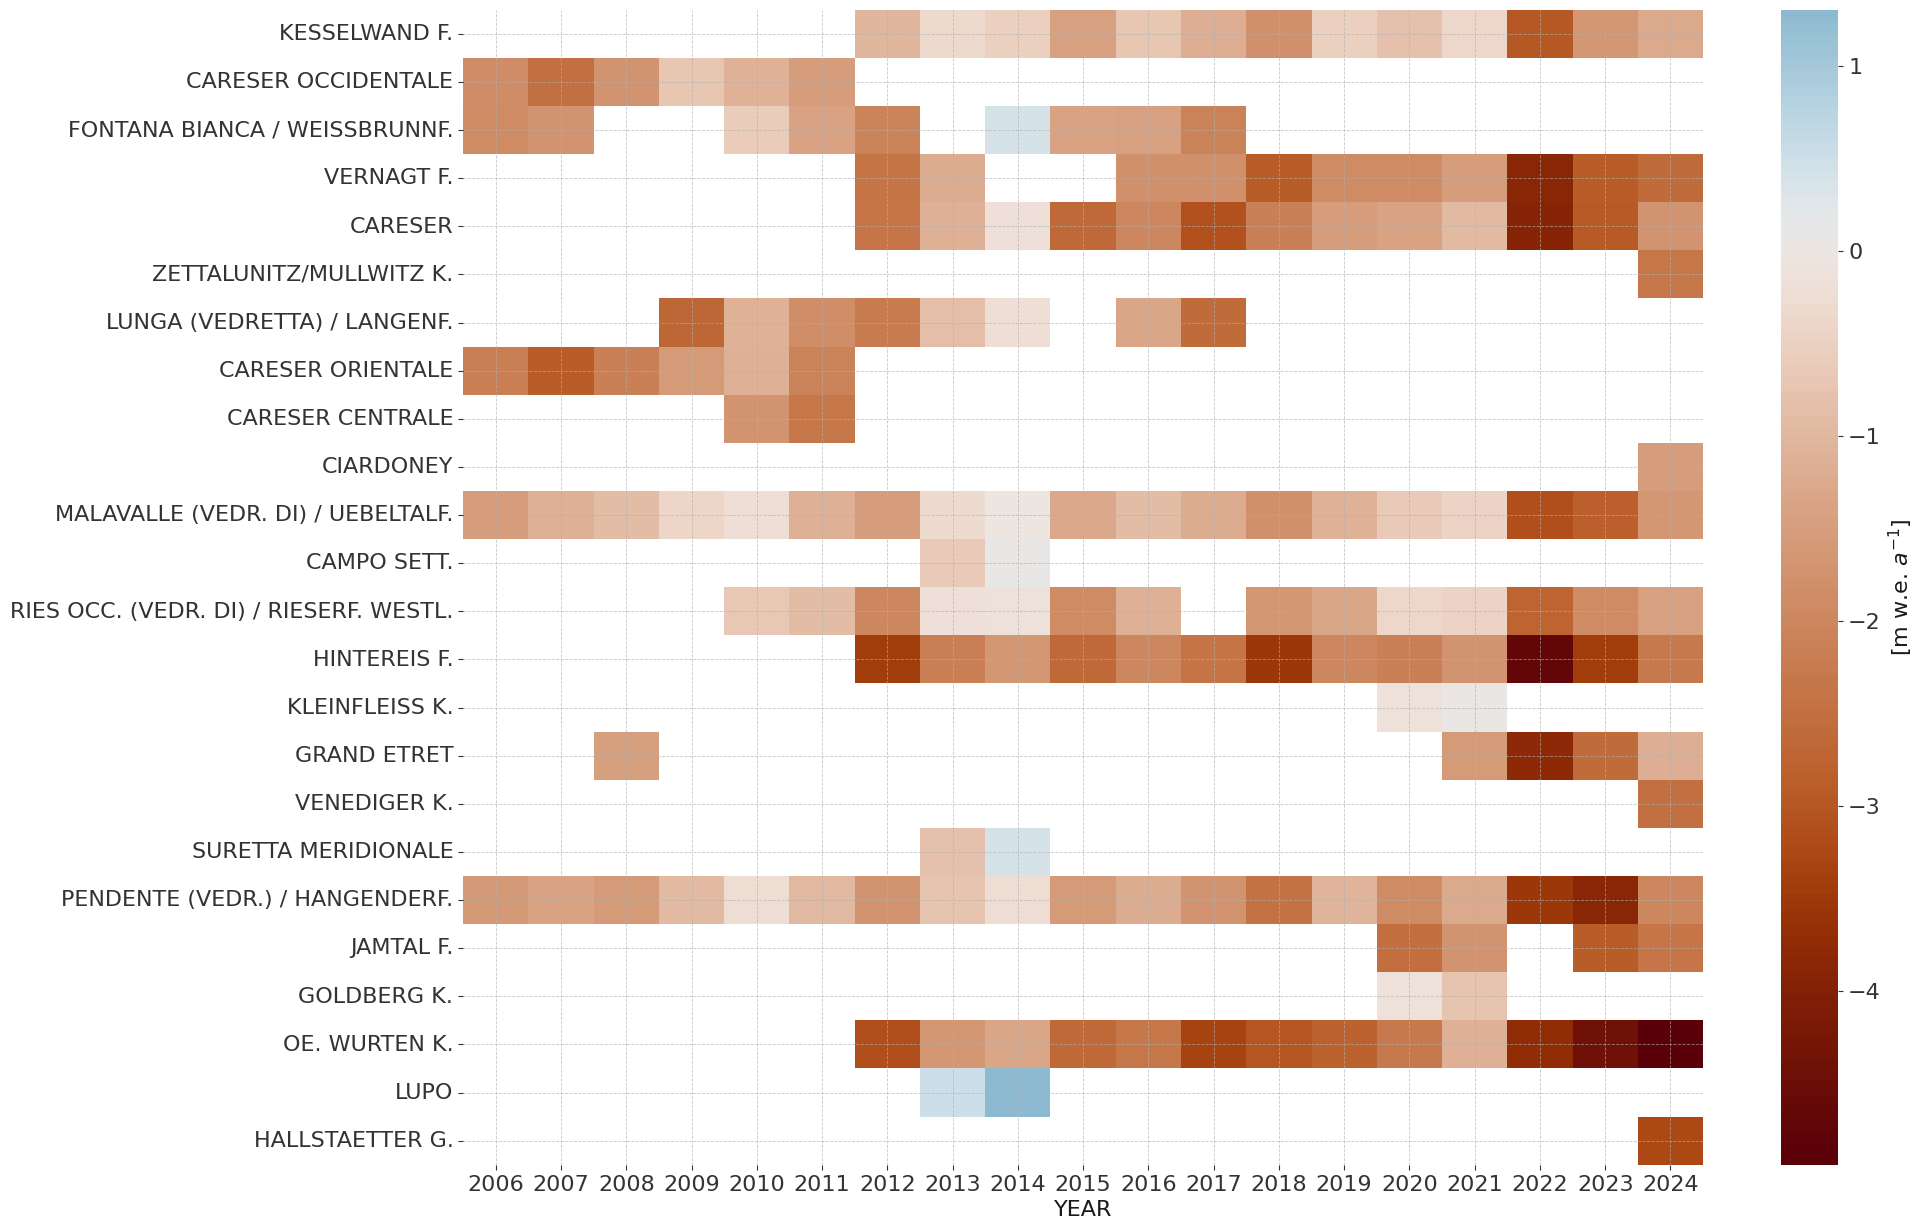

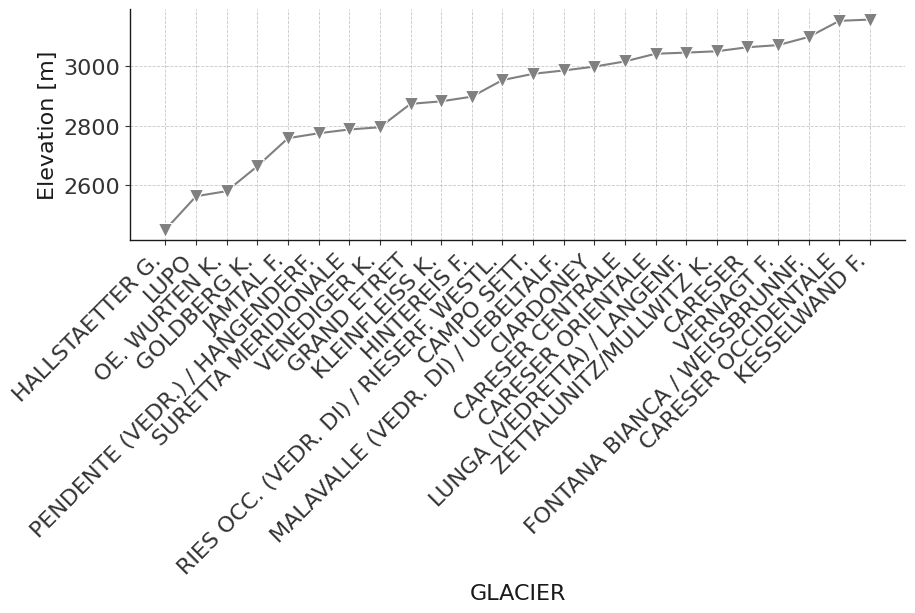

In [4]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_wgms.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_wgms.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

In [5]:
data_wgms_test = data_wgms.copy()

display(data_wgms_test.shape)
display(data_wgms_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_scratch.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_scratch.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

(5086, 16)

POINT_ID  POINT_LAT  POINT_LON  POINT_ELEVATION  \
0  GOLDBERG K._2020_43346_AT  47.041127  12.965073           2700.0   
1  GOLDBERG K._2020_43383_AT  47.043262  12.979787           2410.0   

   FROM_DATE   TO_DATE  POINT_BALANCE      GLACIER  PERIOD           RGIId  \
0   20190920  20200922          0.276  GOLDBERG K.  annual  RGI60-11.00289   
1   20190920  20200922         -1.278  GOLDBERG K.  annual  RGI60-11.00289   

   YEAR      aspect      slope    topo  hugonnet_dhdt  consensus_ice_thickness  
0  2020   48.343734   8.445758  2697.0      -1.065098                48.199932  
1  2020  349.177712  16.786407  2421.0      -1.196566                12.570357

2025-05-15 08:30:29,736 - INFO - Loaded preprocessed data.
2025-05-15 08:30:29,737 - INFO - Number of monthly rows: 51684
2025-05-15 08:30:29,744 - INFO - Number of annual rows: 35814
2025-05-15 08:30:29,749 - INFO - Number of winter rows: 12920


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2020  12.965073  47.041127          0.276       2005.391746   
1  2020  12.965073  47.041127          0.276       2005.391746   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            694.608254           2700.0  RGI60-11.00289   
1            694.608254           2700.0  RGI60-11.00289   

                    POINT_ID  ID  ...  consensus_ice_thickness       t2m  \
0  GOLDBERG K._2020_43346_AT   0  ...                48.199932  4.488969   
1  GOLDBERG K._2020_43346_AT   0  ...                48.199932 -2.252254   

         tp          slhf          sshf          ssrd       fal           str  \
0  0.003263 -2.294197e+06 -1.238352e+06  9.166772e+06  0.229960 -3.531357e+06   
1  0.011190 -3.506452e+05 -2.978029e+05  5.373250e+06  0.610373 -2.029104e+06   

        u10       v10  
0  0.265244  0.430310  
1  0.098150  0.601325  

[2 rows x 27 columns]

#### Feature Correlation

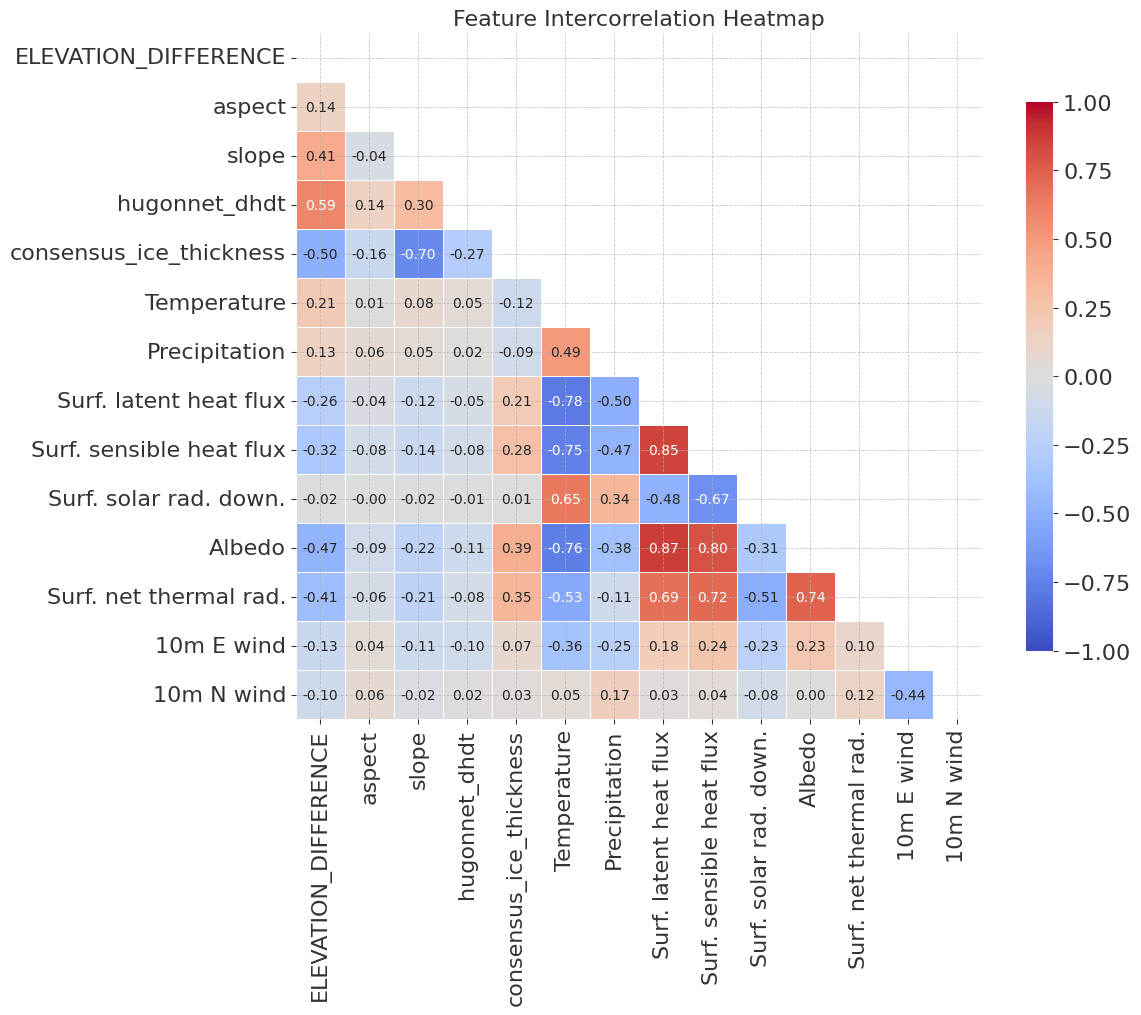

In [6]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'GLWD_ID', 'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

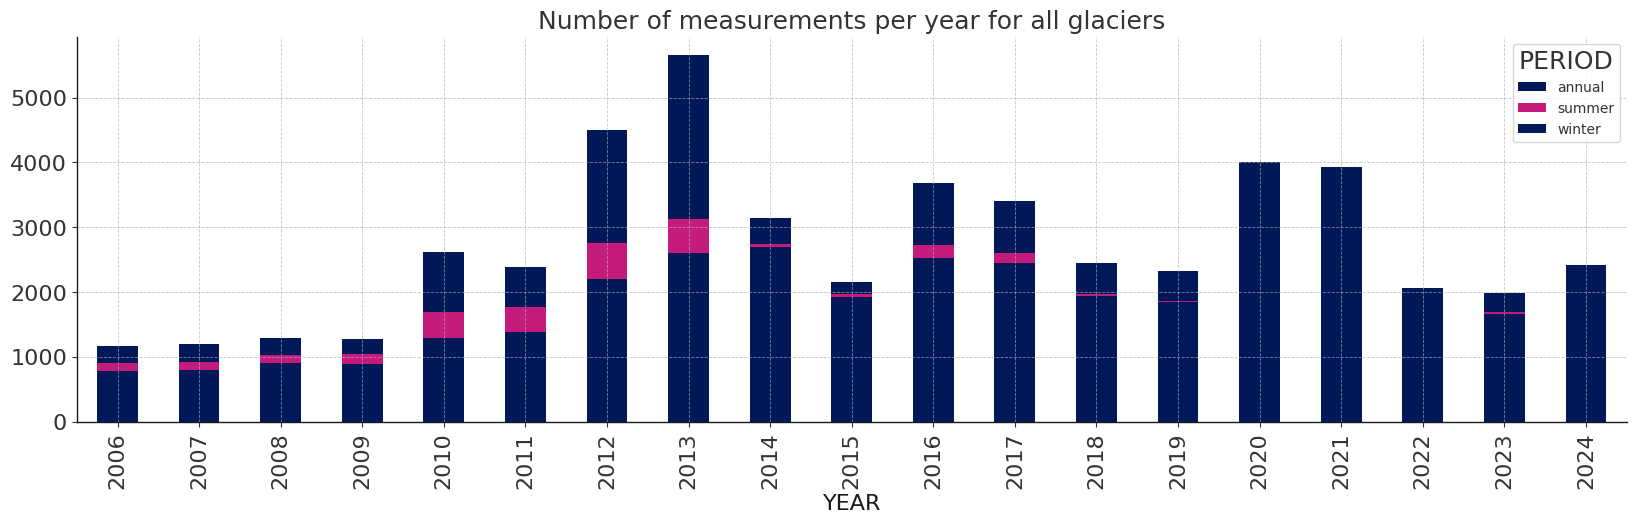

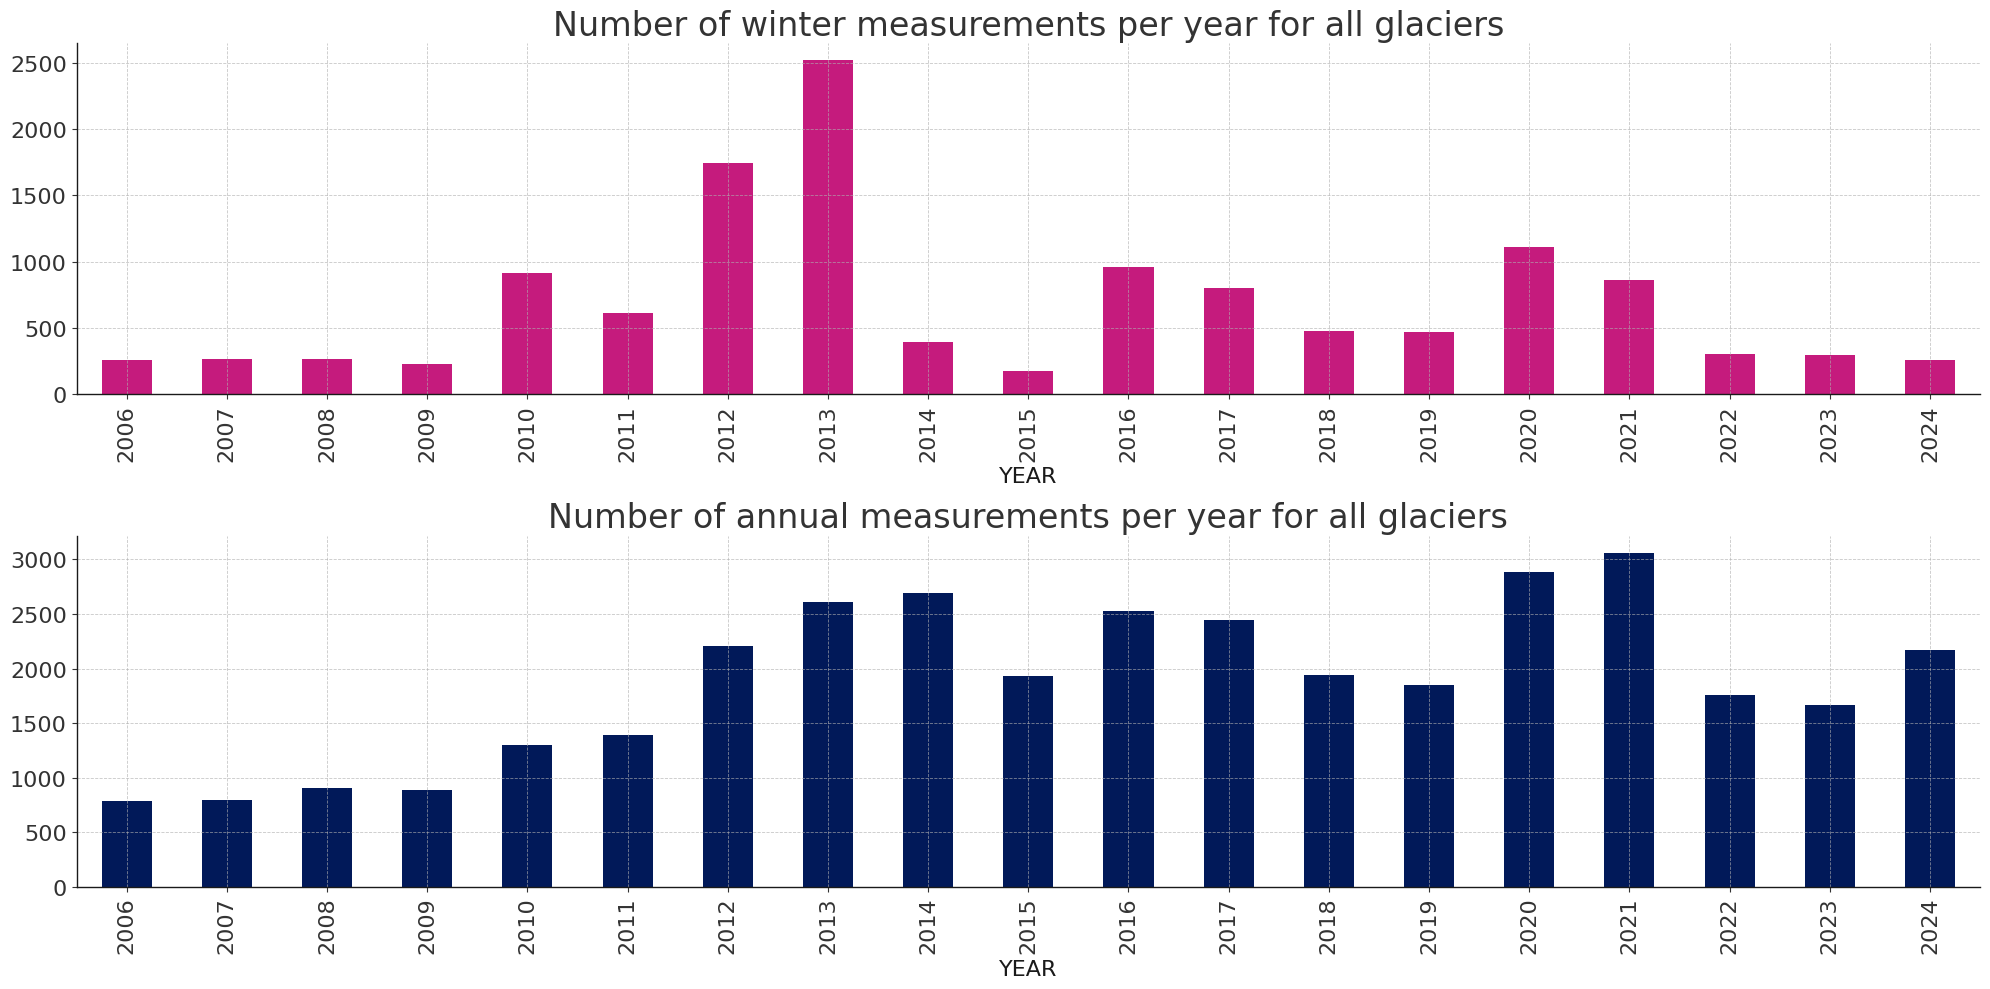

In [7]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

#### Sanity Check

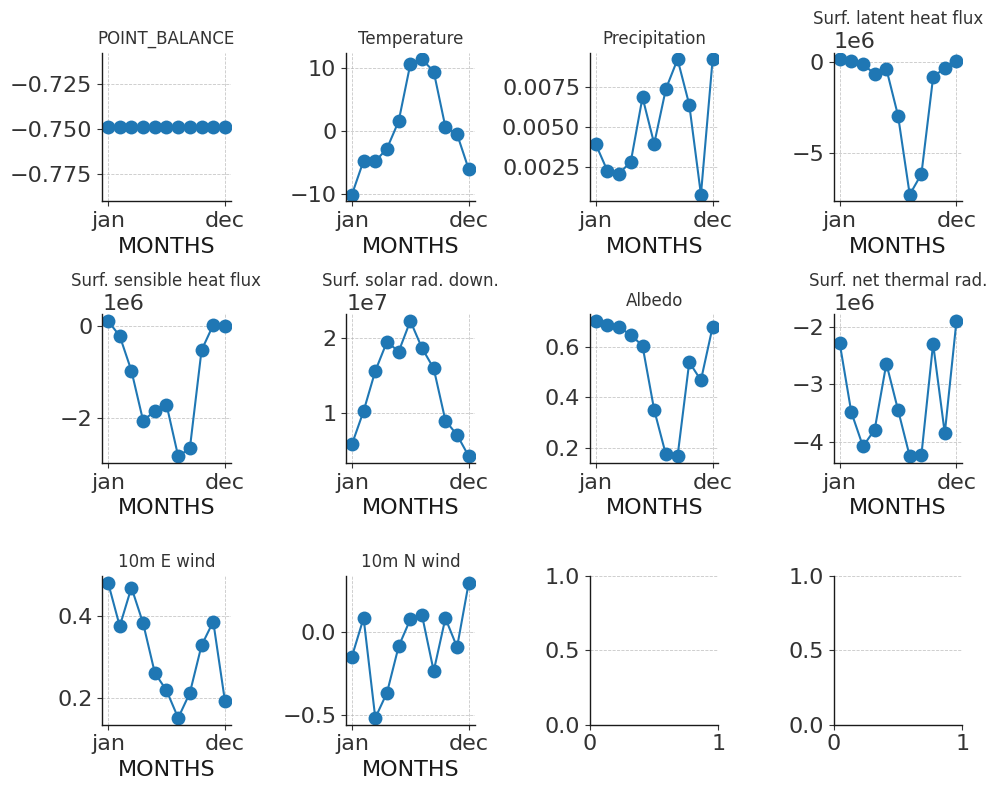

In [8]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'GOLDBERG K.') & (df.YEAR == 2021)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

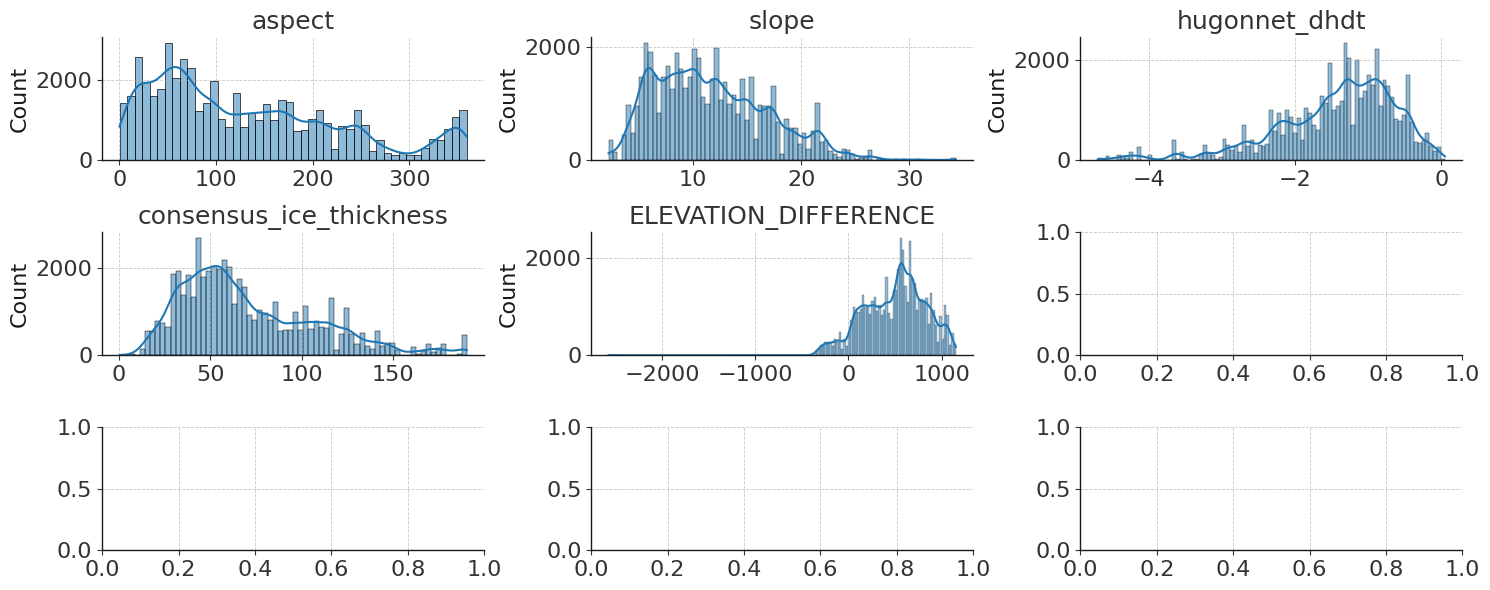

In [9]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [10]:
display(df['GLACIER'].unique())

# Remove summer stakes
dataloader_gl.data = dataloader_gl.data[dataloader_gl.data['PERIOD'] != 'summer']
dataloader_gl.data = dataloader_gl.data.reset_index(drop=True)
data_monthly = dataloader_gl.data

display(dataloader_gl.data['PERIOD'].unique())
display(data_monthly['PERIOD'].unique())

array(['GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
       'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
       'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.', 'CAMPO SETT.', 'CARESER',
       'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE',
       'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GRAND ETRET',
       'LUNGA (VEDRETTA) / LANGENF.', 'LUPO',
       'MALAVALLE (VEDR. DI) / UEBELTALF.',
       'PENDENTE (VEDR.) / HANGENDERF.',
       'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE'],
      dtype=object)

array(['annual', 'winter'], dtype=object)

array(['annual', 'winter'], dtype=object)

#### Train IT, Test AT

In [11]:
test_glaciers = [
    'GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
    'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
    'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 22012
Size of train data: 26722
Percentage of test size: 82.37%
Train:
Number of winter and annual samples: 26722
Number of annual samples: 19940
Number of winter samples: 6782
Test:
Number of winter and annual samples: 22012
Number of annual samples: 15874
Number of winter samples: 6138
Total:
Number of monthly rows: 48734
Number of annual rows: 35814
Number of winter rows: 12920


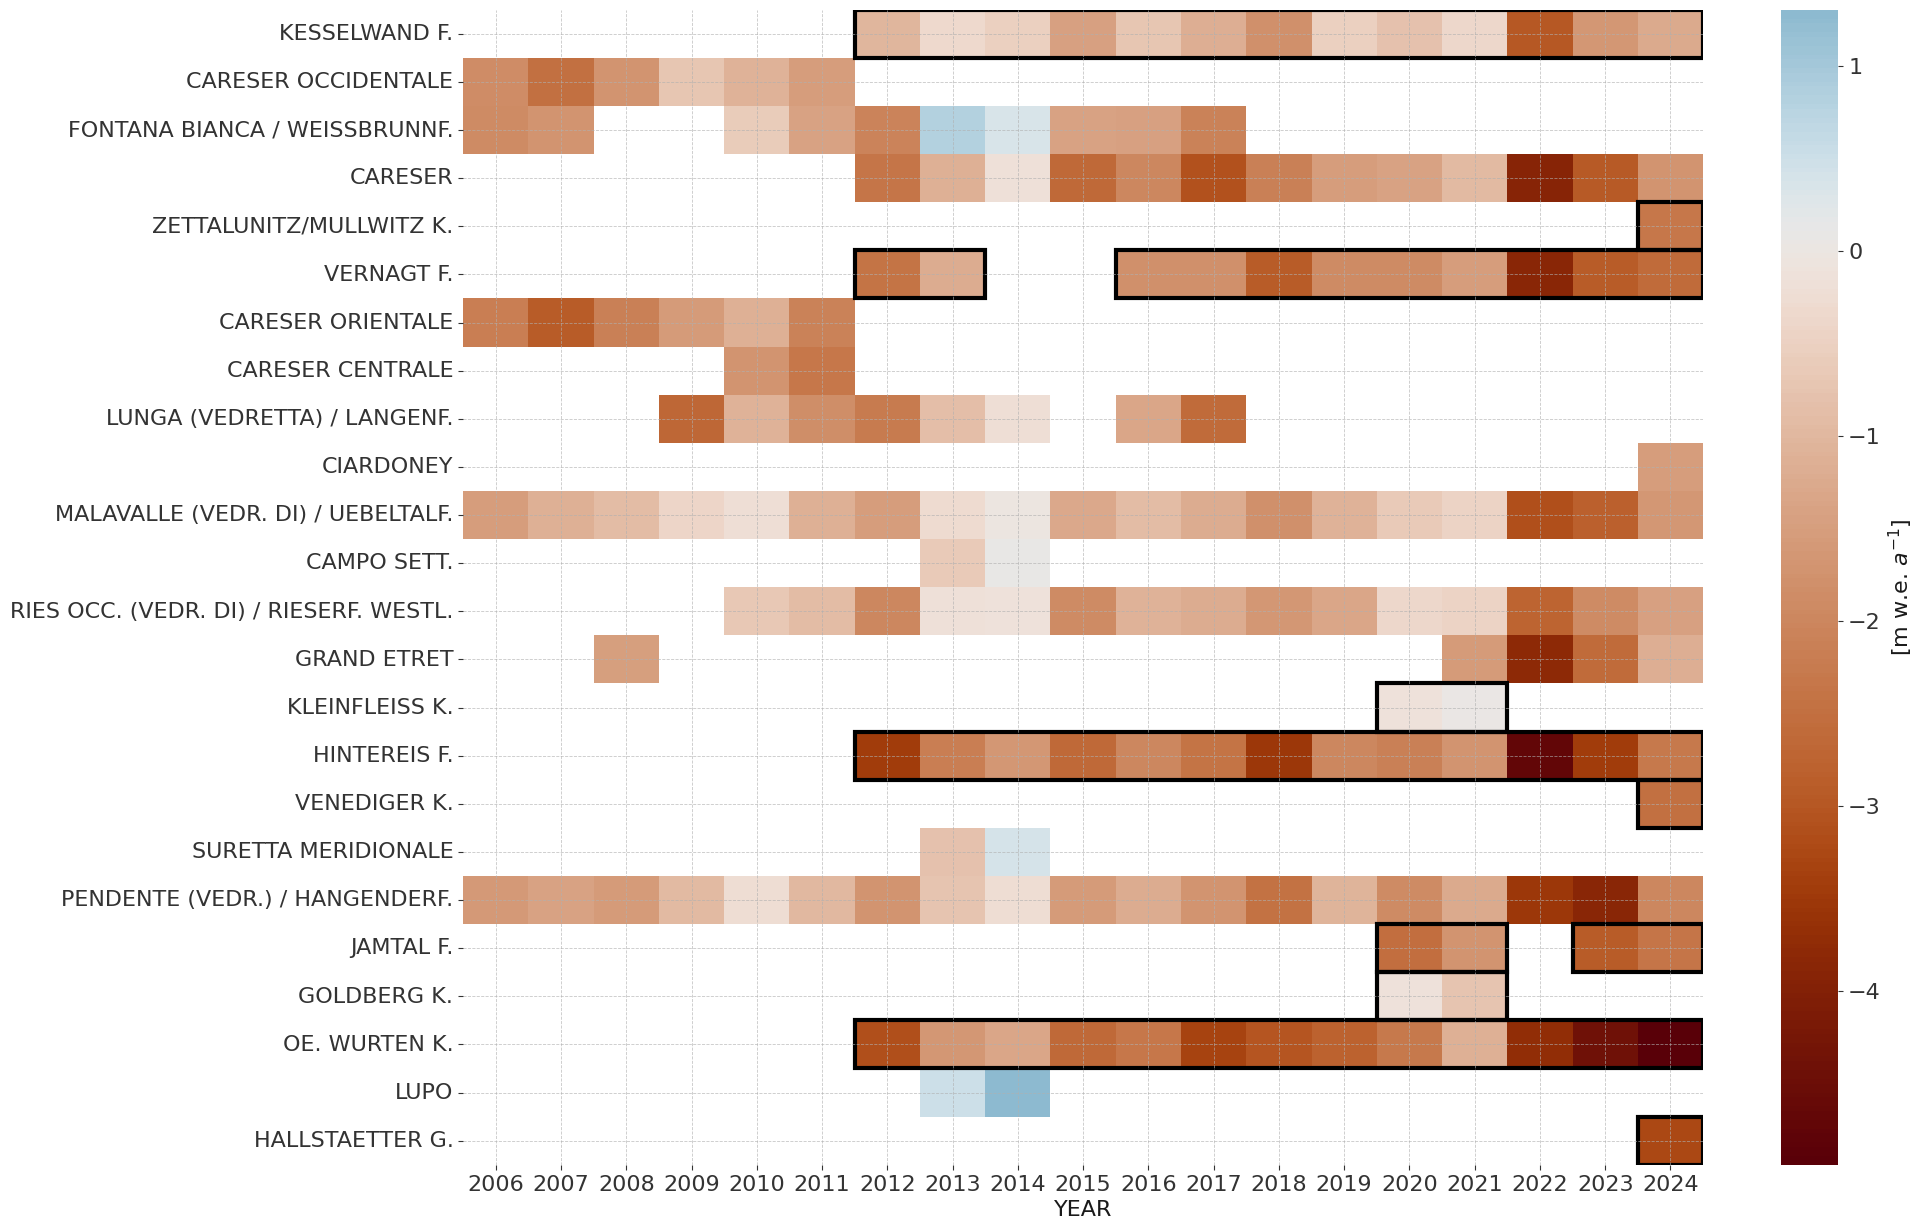

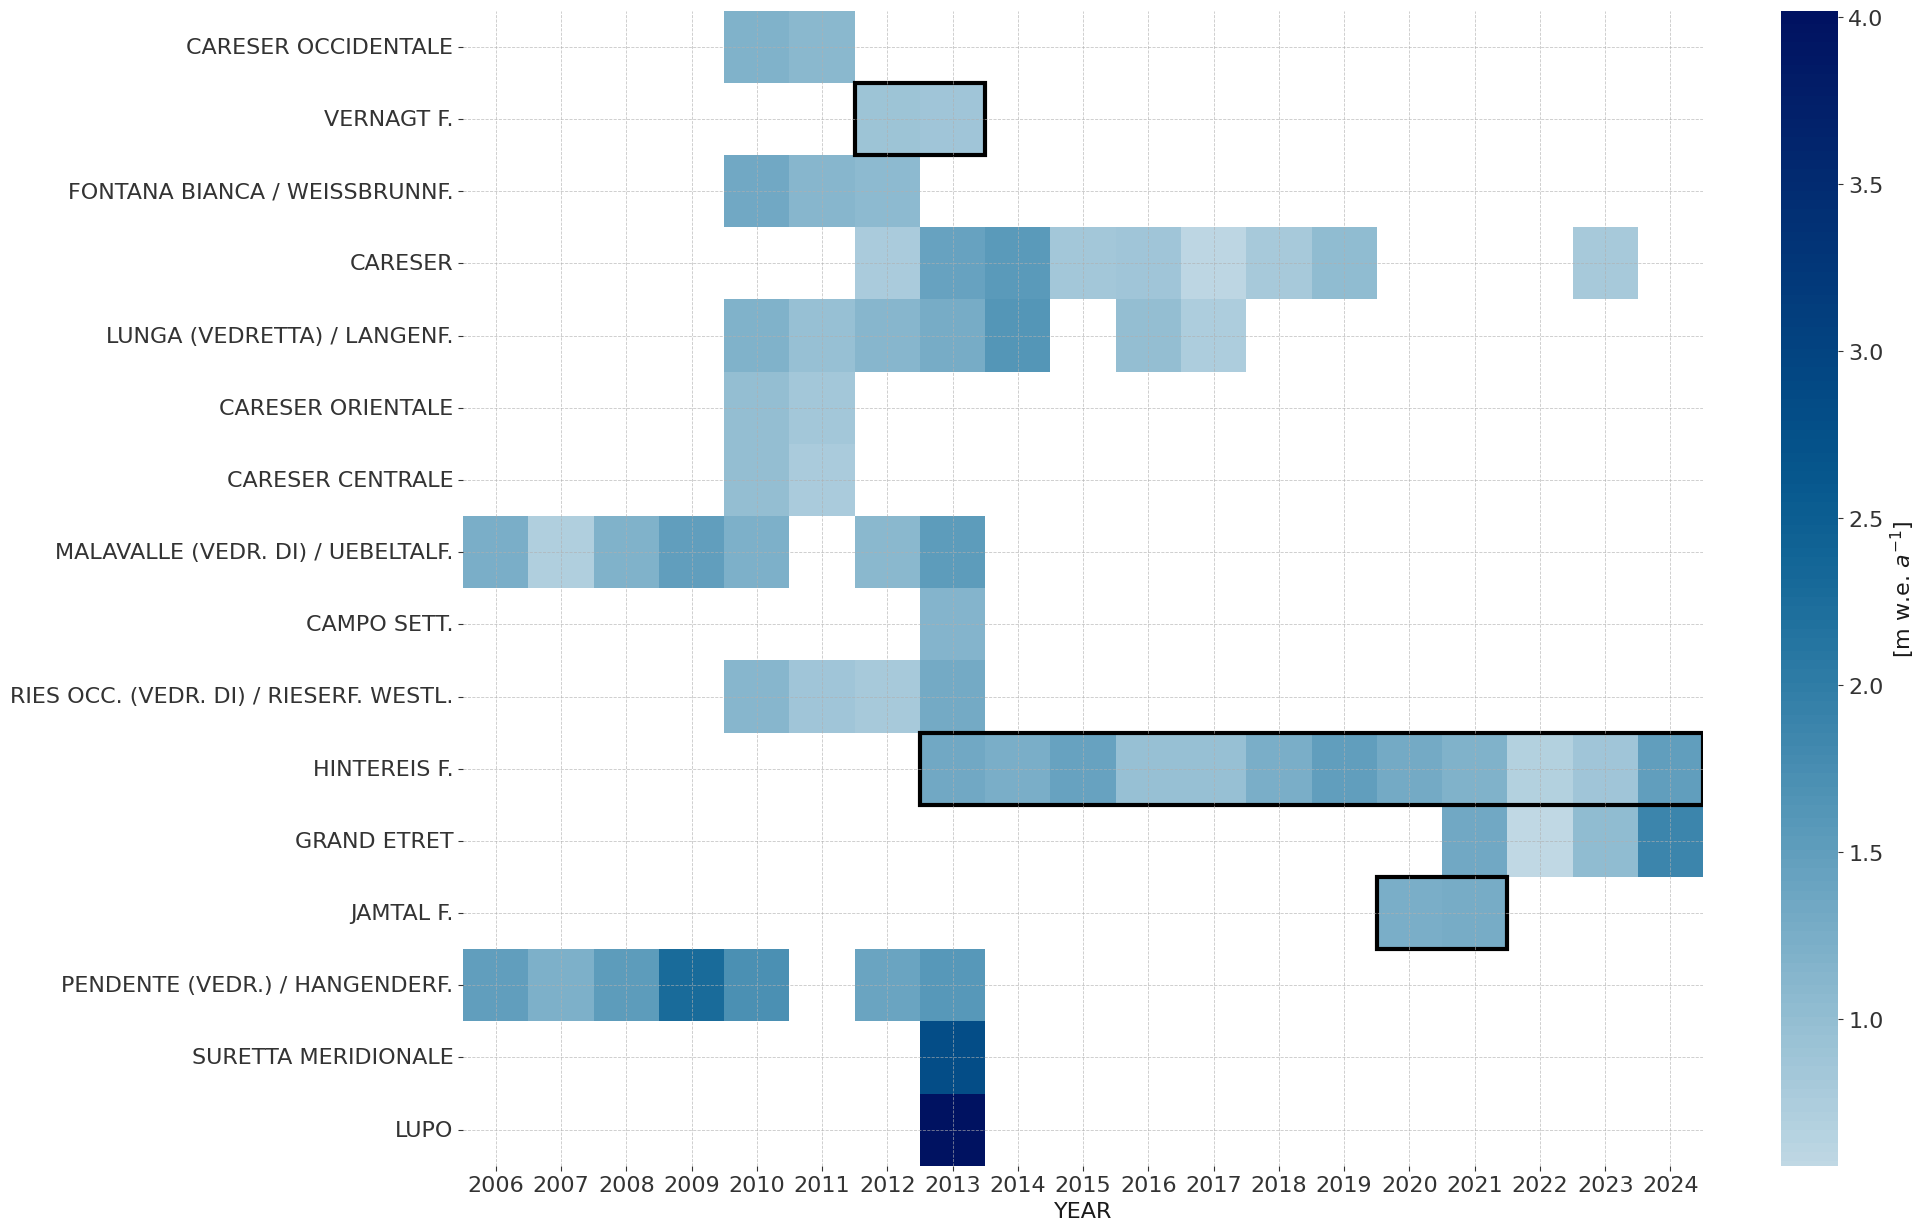

In [22]:
plotHeatmap(test_glaciers, data_monthly, period='annual')

plotHeatmap(test_glaciers, data_monthly, period='winter')

Test glaciers: (10) ['GOLDBERG K.' 'HALLSTAETTER G.' 'HINTEREIS F.' 'JAMTAL F.'
 'KESSELWAND F.' 'KLEINFLEISS K.' 'OE. WURTEN K.' 'VENEDIGER K.'
 'VERNAGT F.' 'ZETTALUNITZ/MULLWITZ K.']
Percentage of test size: 82.37%
Size of test set: 22012
Train glaciers: (14) ['CAMPO SETT.' 'CARESER' 'CARESER CENTRALE' 'CARESER OCCIDENTALE'
 'CARESER ORIENTALE' 'CIARDONEY' 'FONTANA BIANCA / WEISSBRUNNF.'
 'GRAND ETRET' 'LUNGA (VEDRETTA) / LANGENF.' 'LUPO'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'SURETTA MERIDIONALE']
Size of train set: 26722


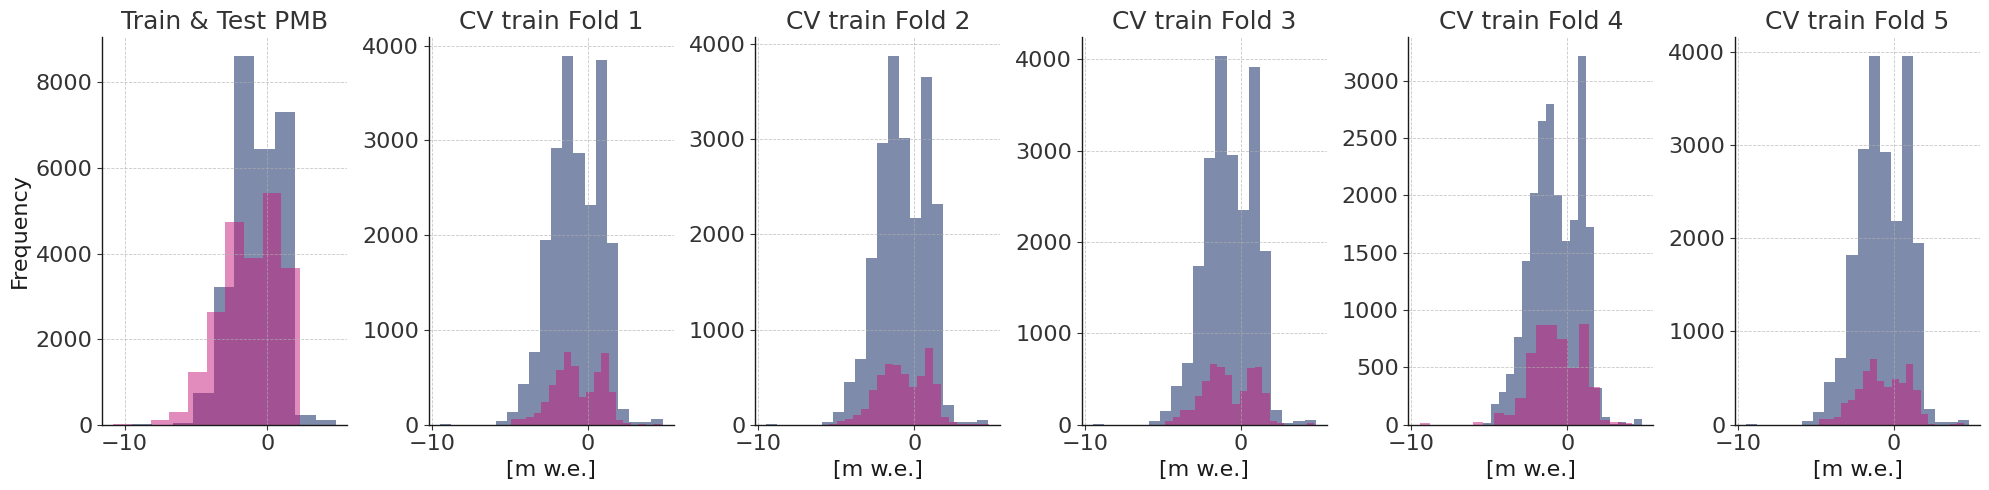

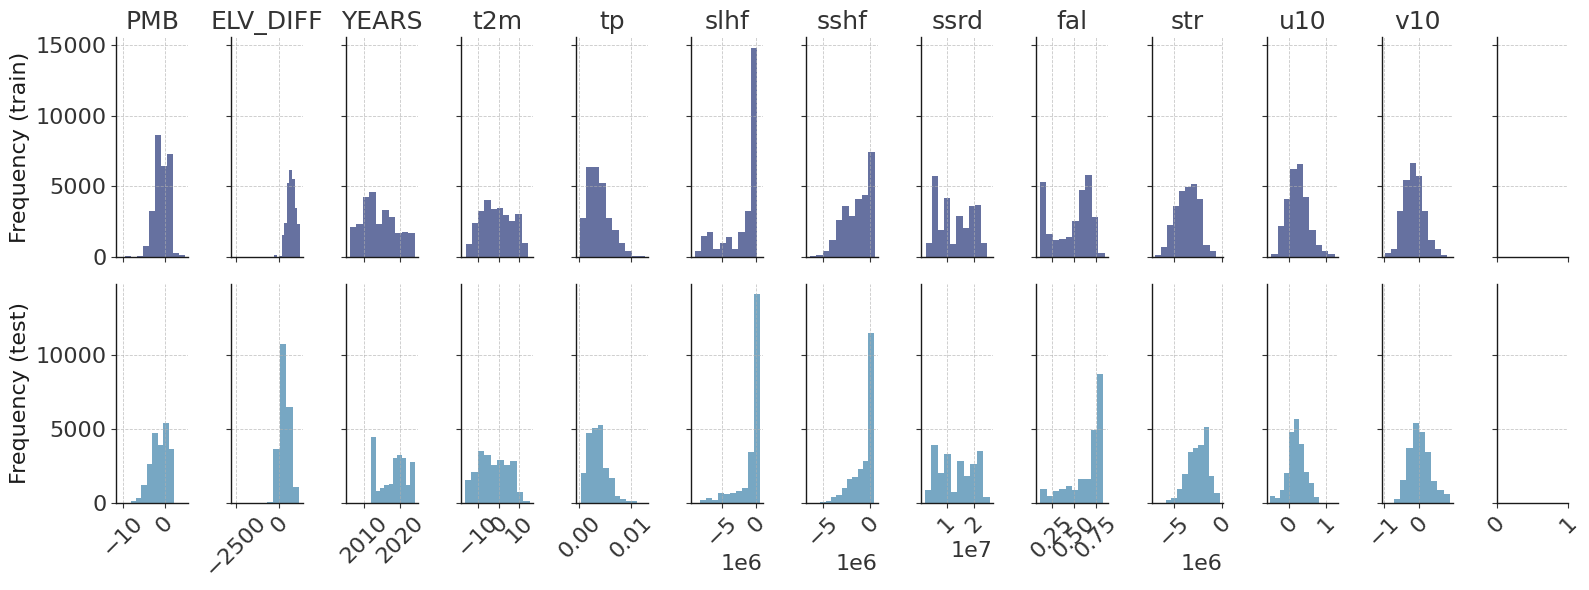

In [12]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

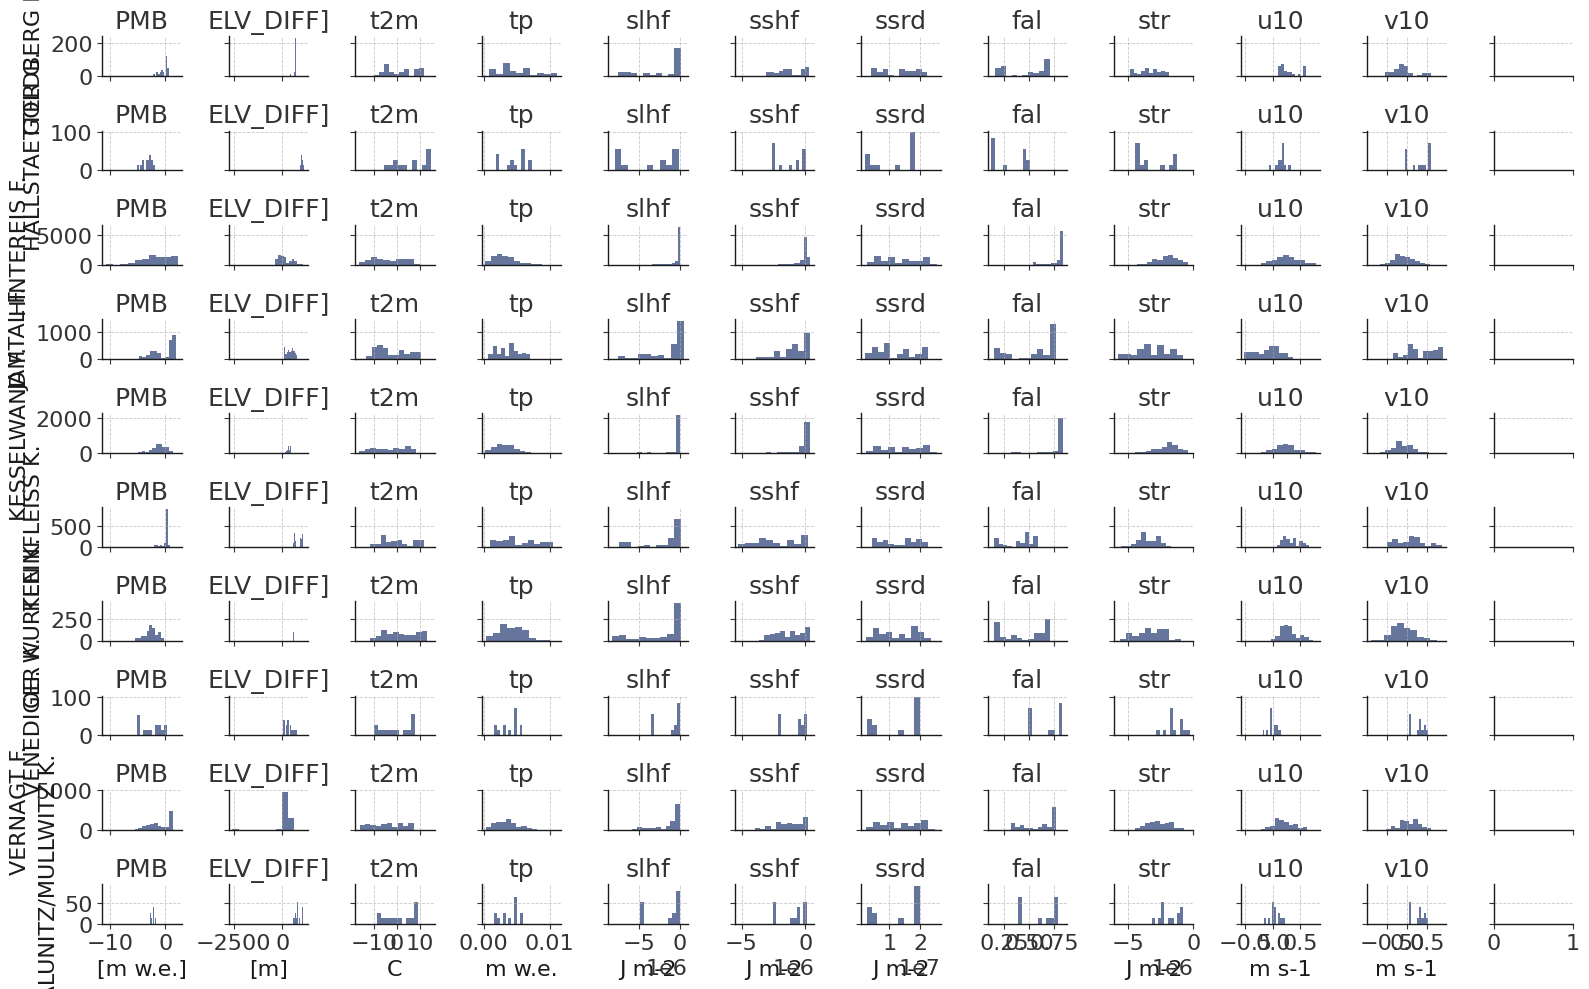

In [13]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

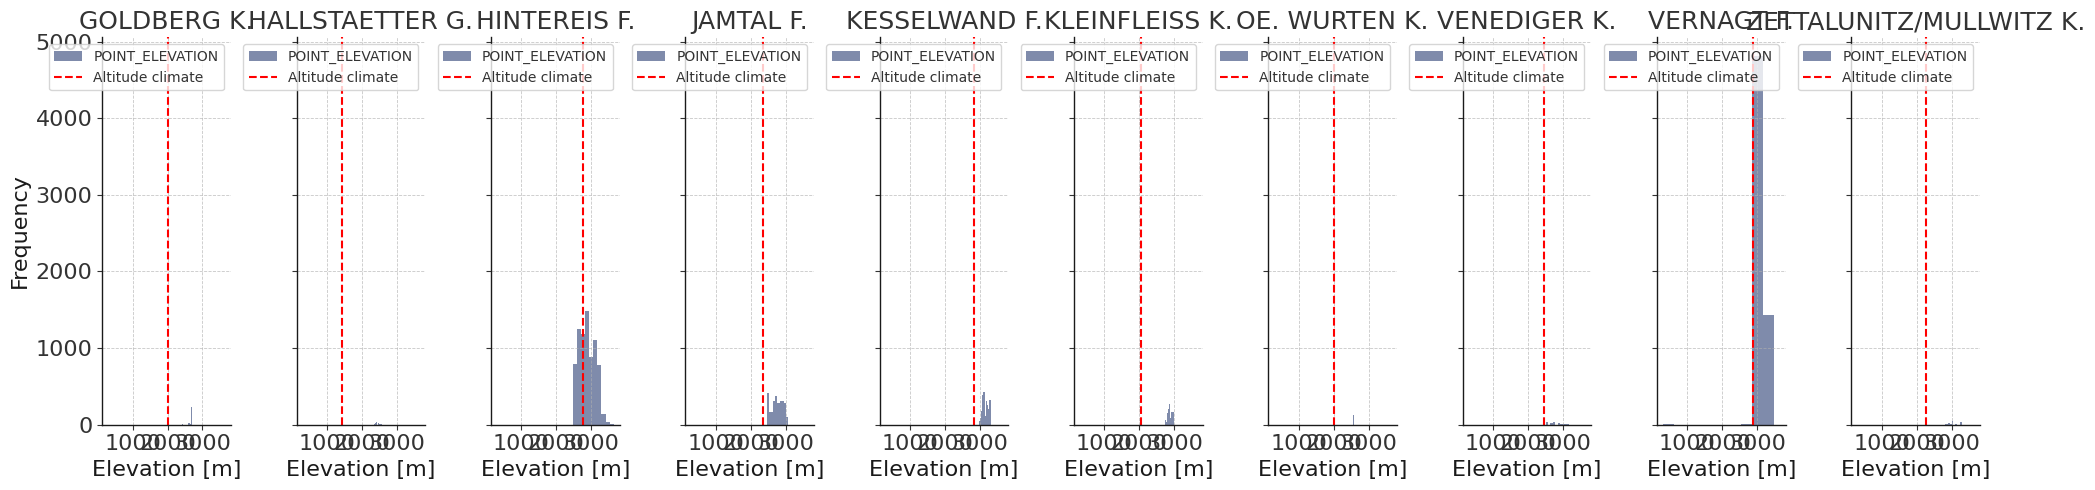

In [14]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

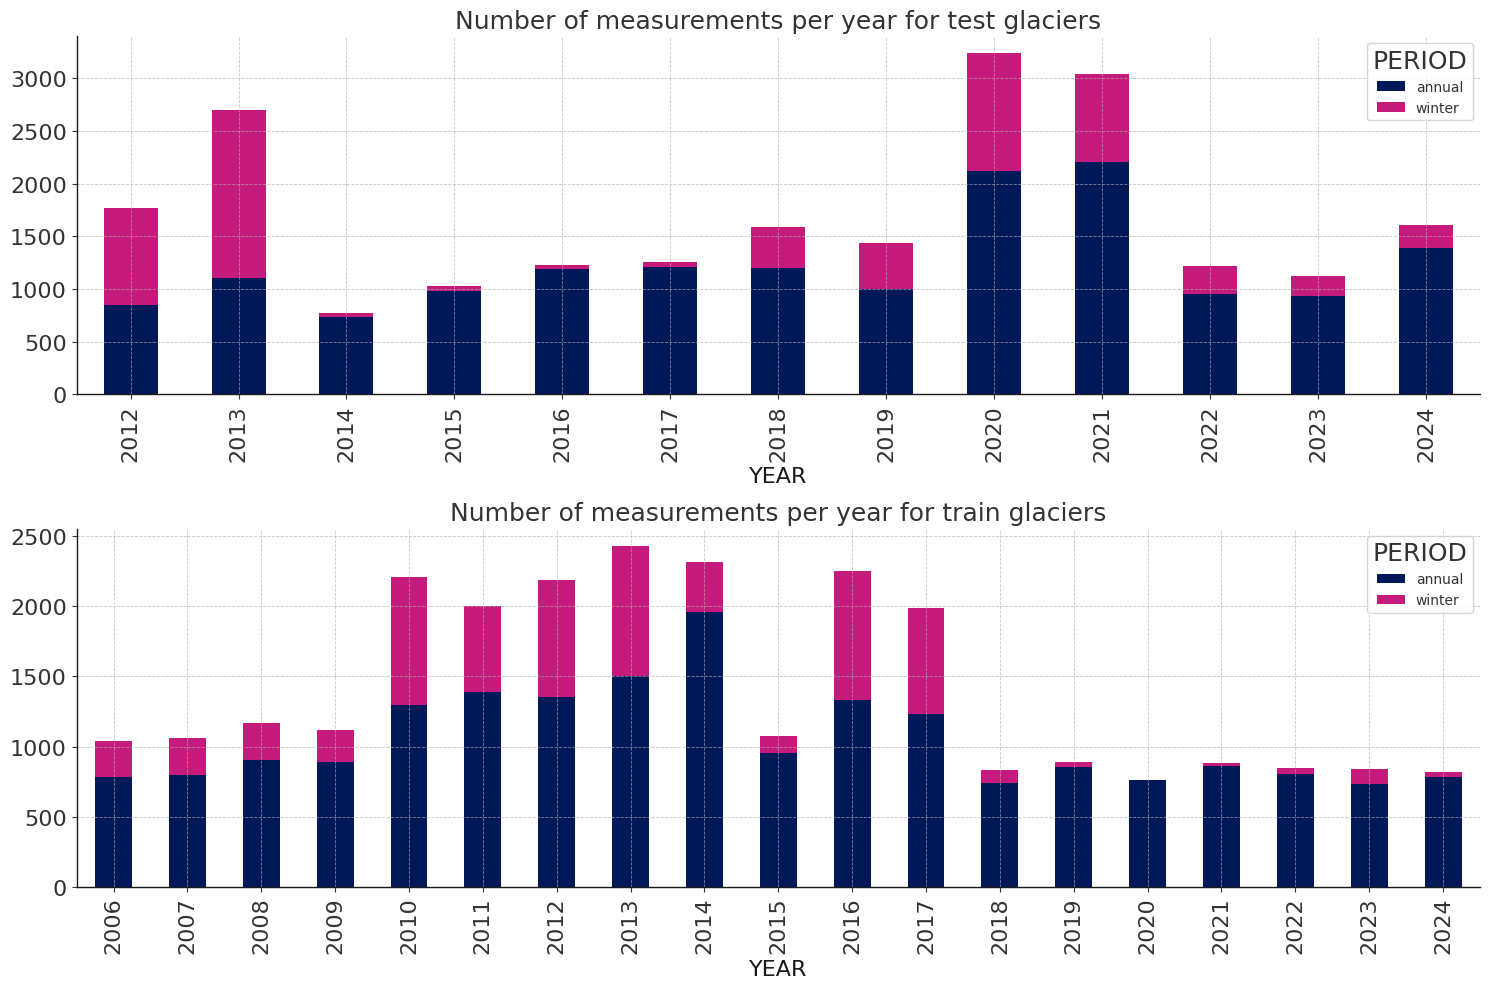

In [15]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [16]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

### Grid search:

In [17]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'IT_train_AT_test.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'IT_train_AT_test.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (26722, 25)
Shape of testing dataset: (22012, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
Best score:
 -0.26938413316898085
Shape of the test: (22012, 14)
Overall score: 7.150870066605481
CPU times: user 2.53 s, sys: 22.4 ms, total: 2.55 s
Wall time: 132 ms


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

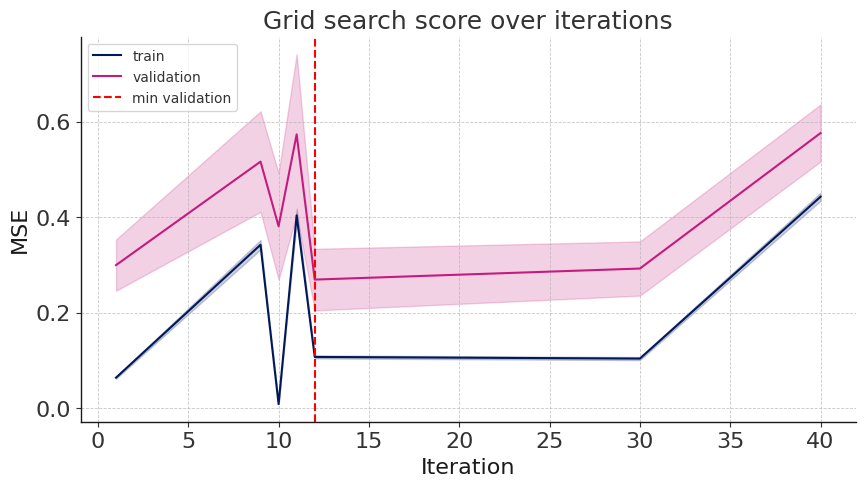

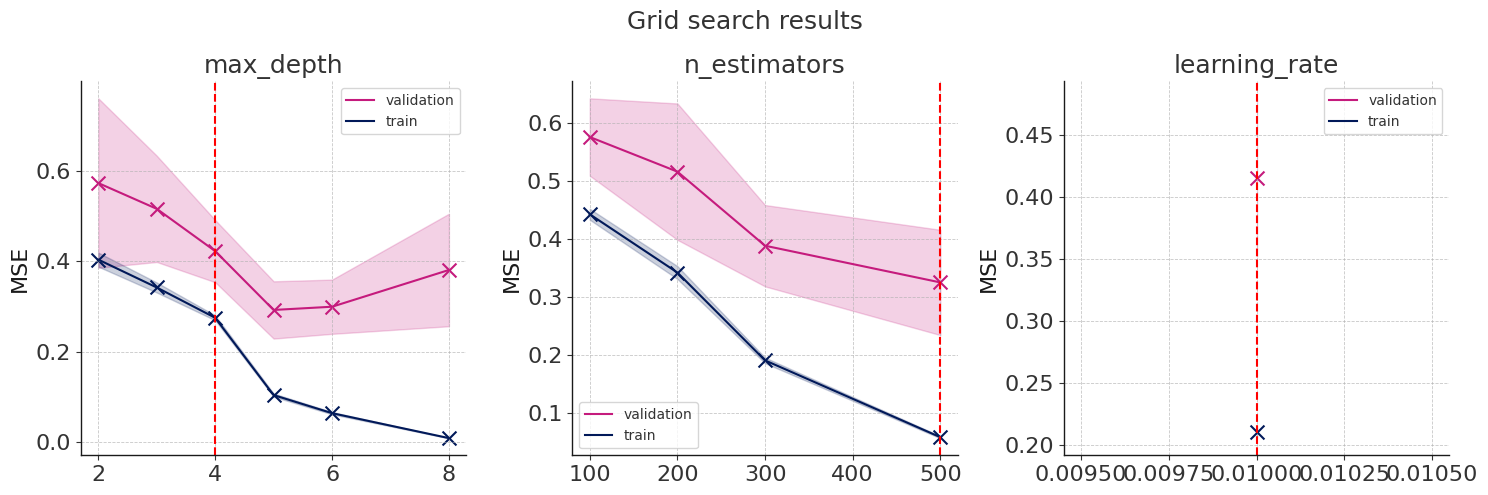

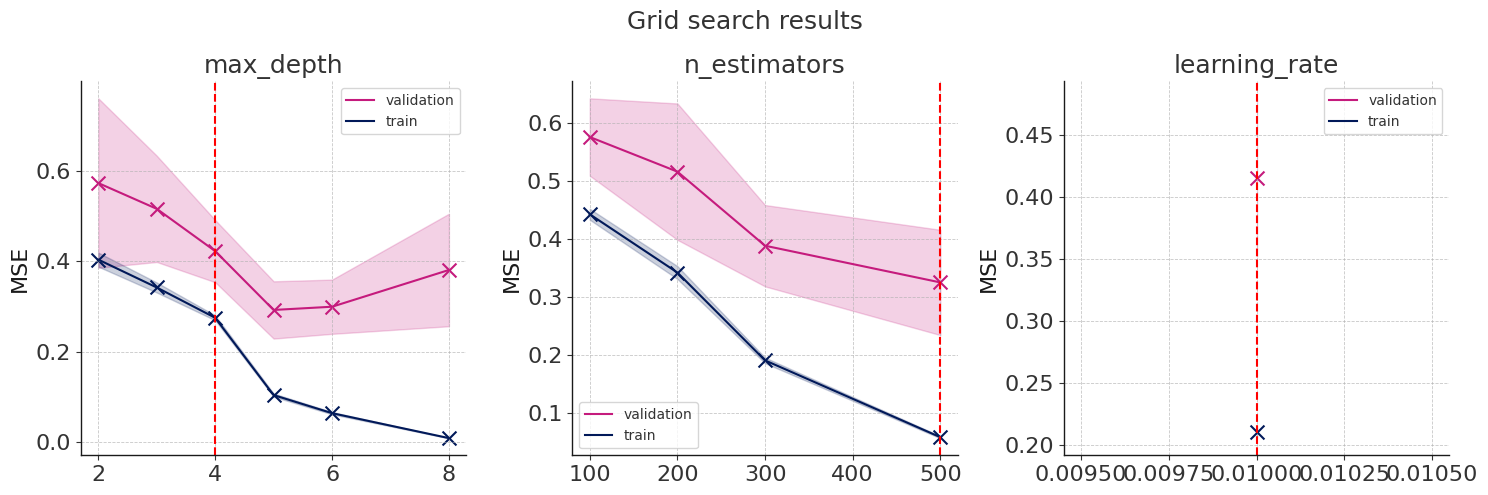

In [18]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

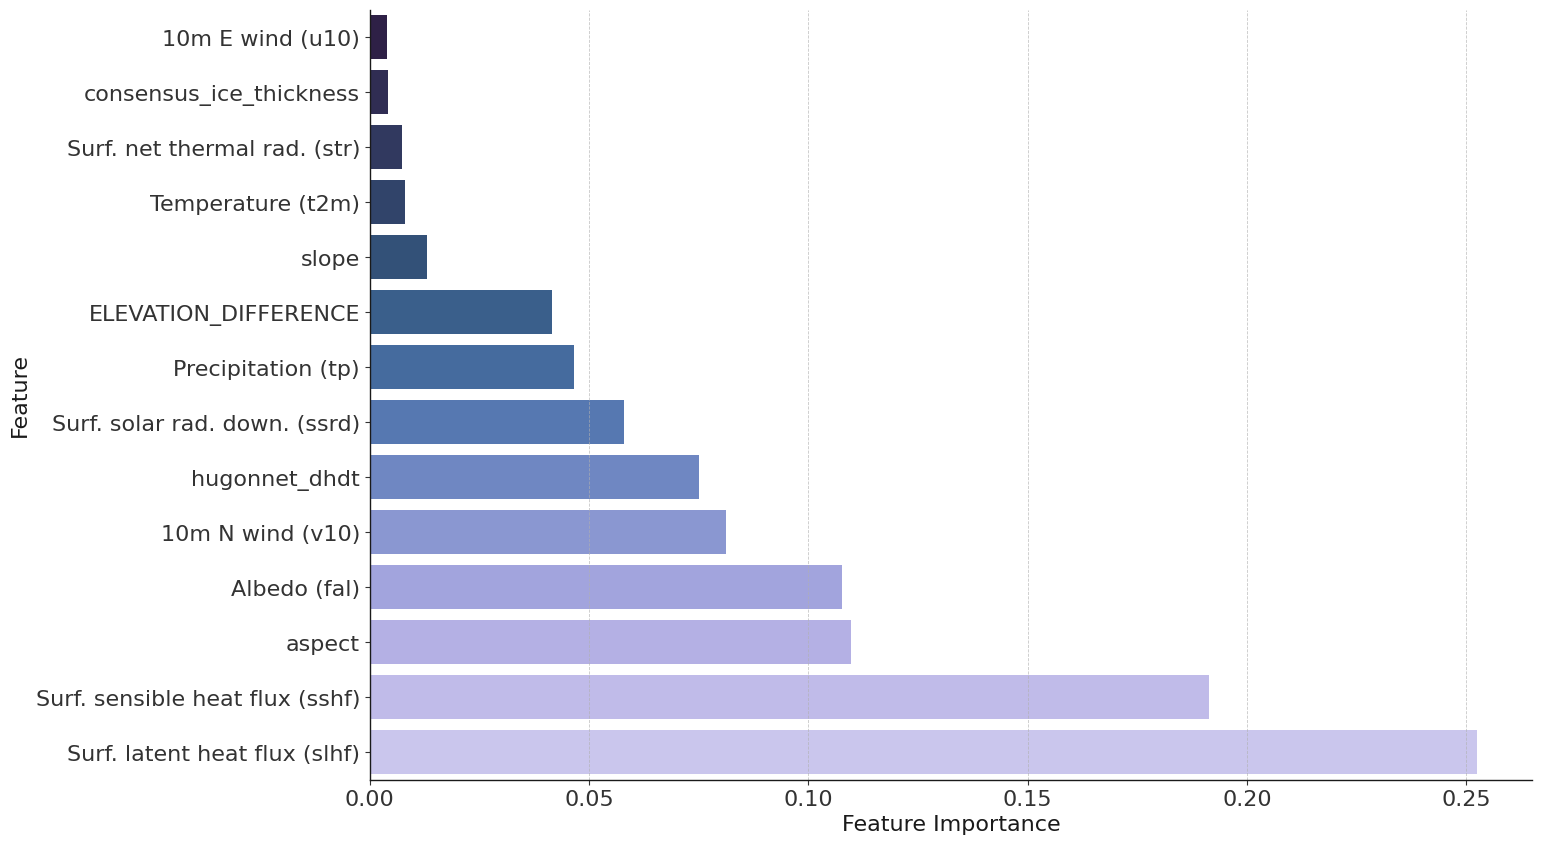

In [19]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (22012, 14)
{'GOLDBERG K.': '#a6cee3', 'HALLSTAETTER G.': '#1f78b4', 'HINTEREIS F.': '#b2df8a', 'JAMTAL F.': '#33a02c', 'KESSELWAND F.': '#fb9a99', 'KLEINFLEISS K.': '#e31a1c', 'OE. WURTEN K.': '#fdbf6f', 'VENEDIGER K.': '#ff7f00', 'VERNAGT F.': '#cab2d6', 'ZETTALUNITZ/MULLWITZ K.': '#6a3d9a'}


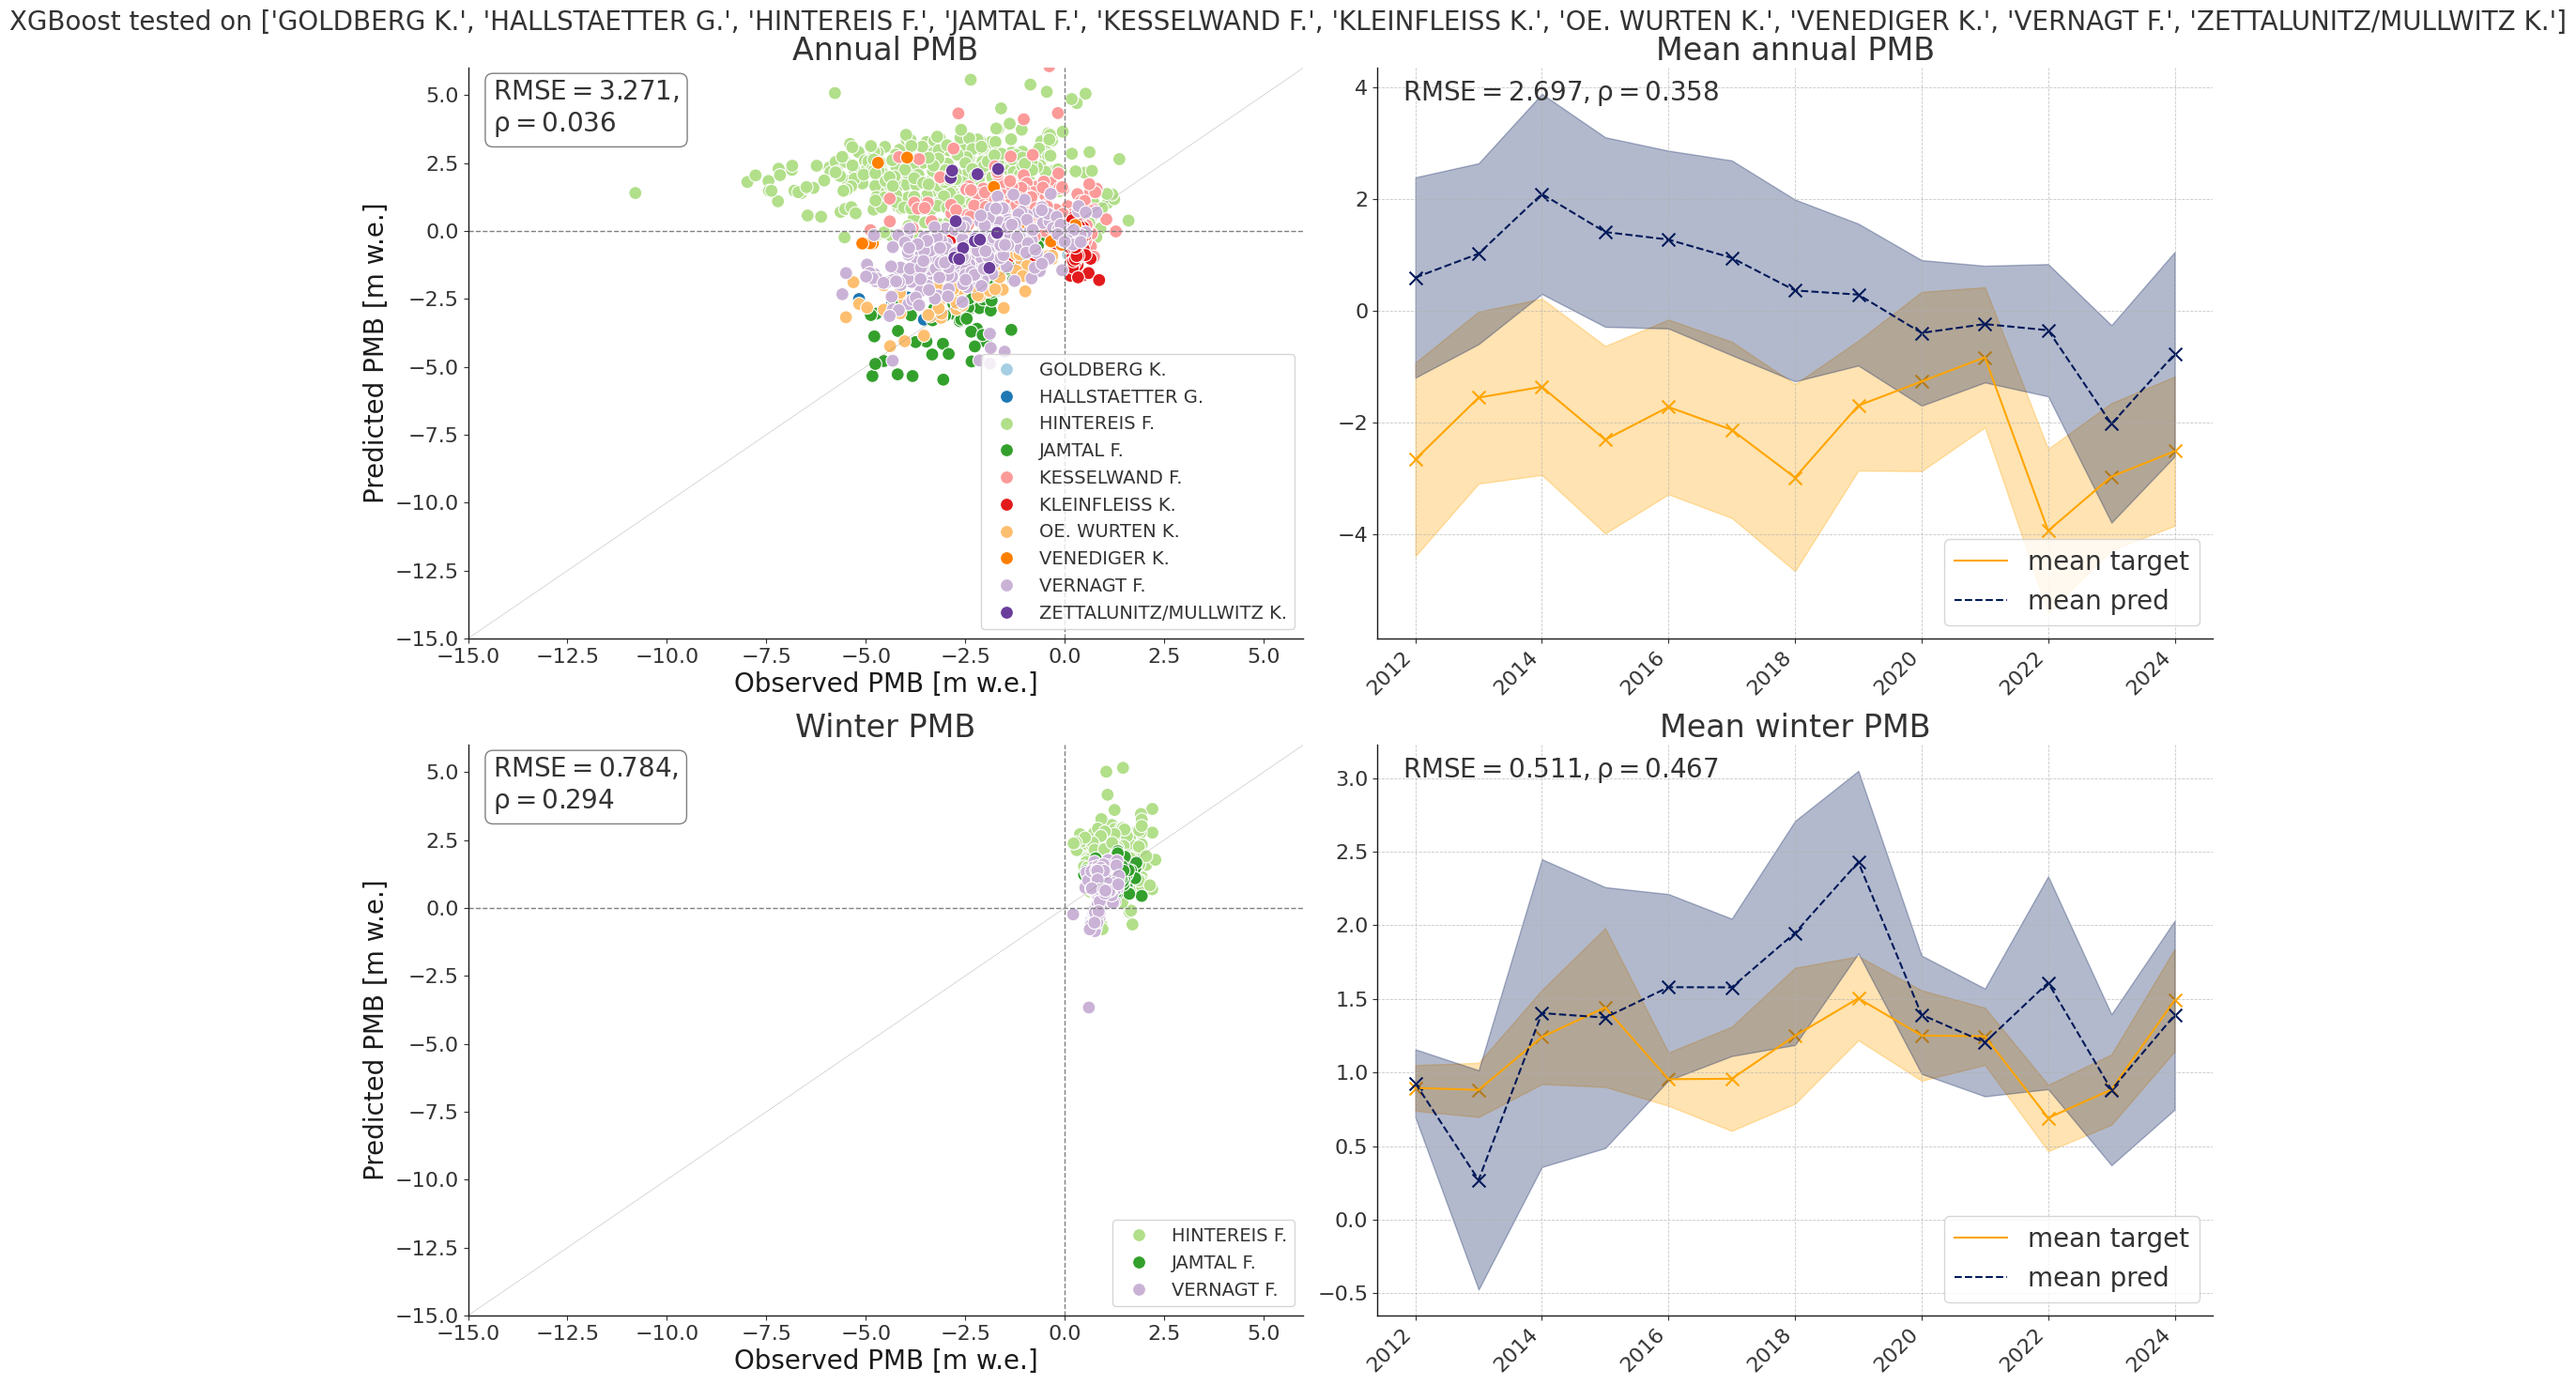

In [20]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

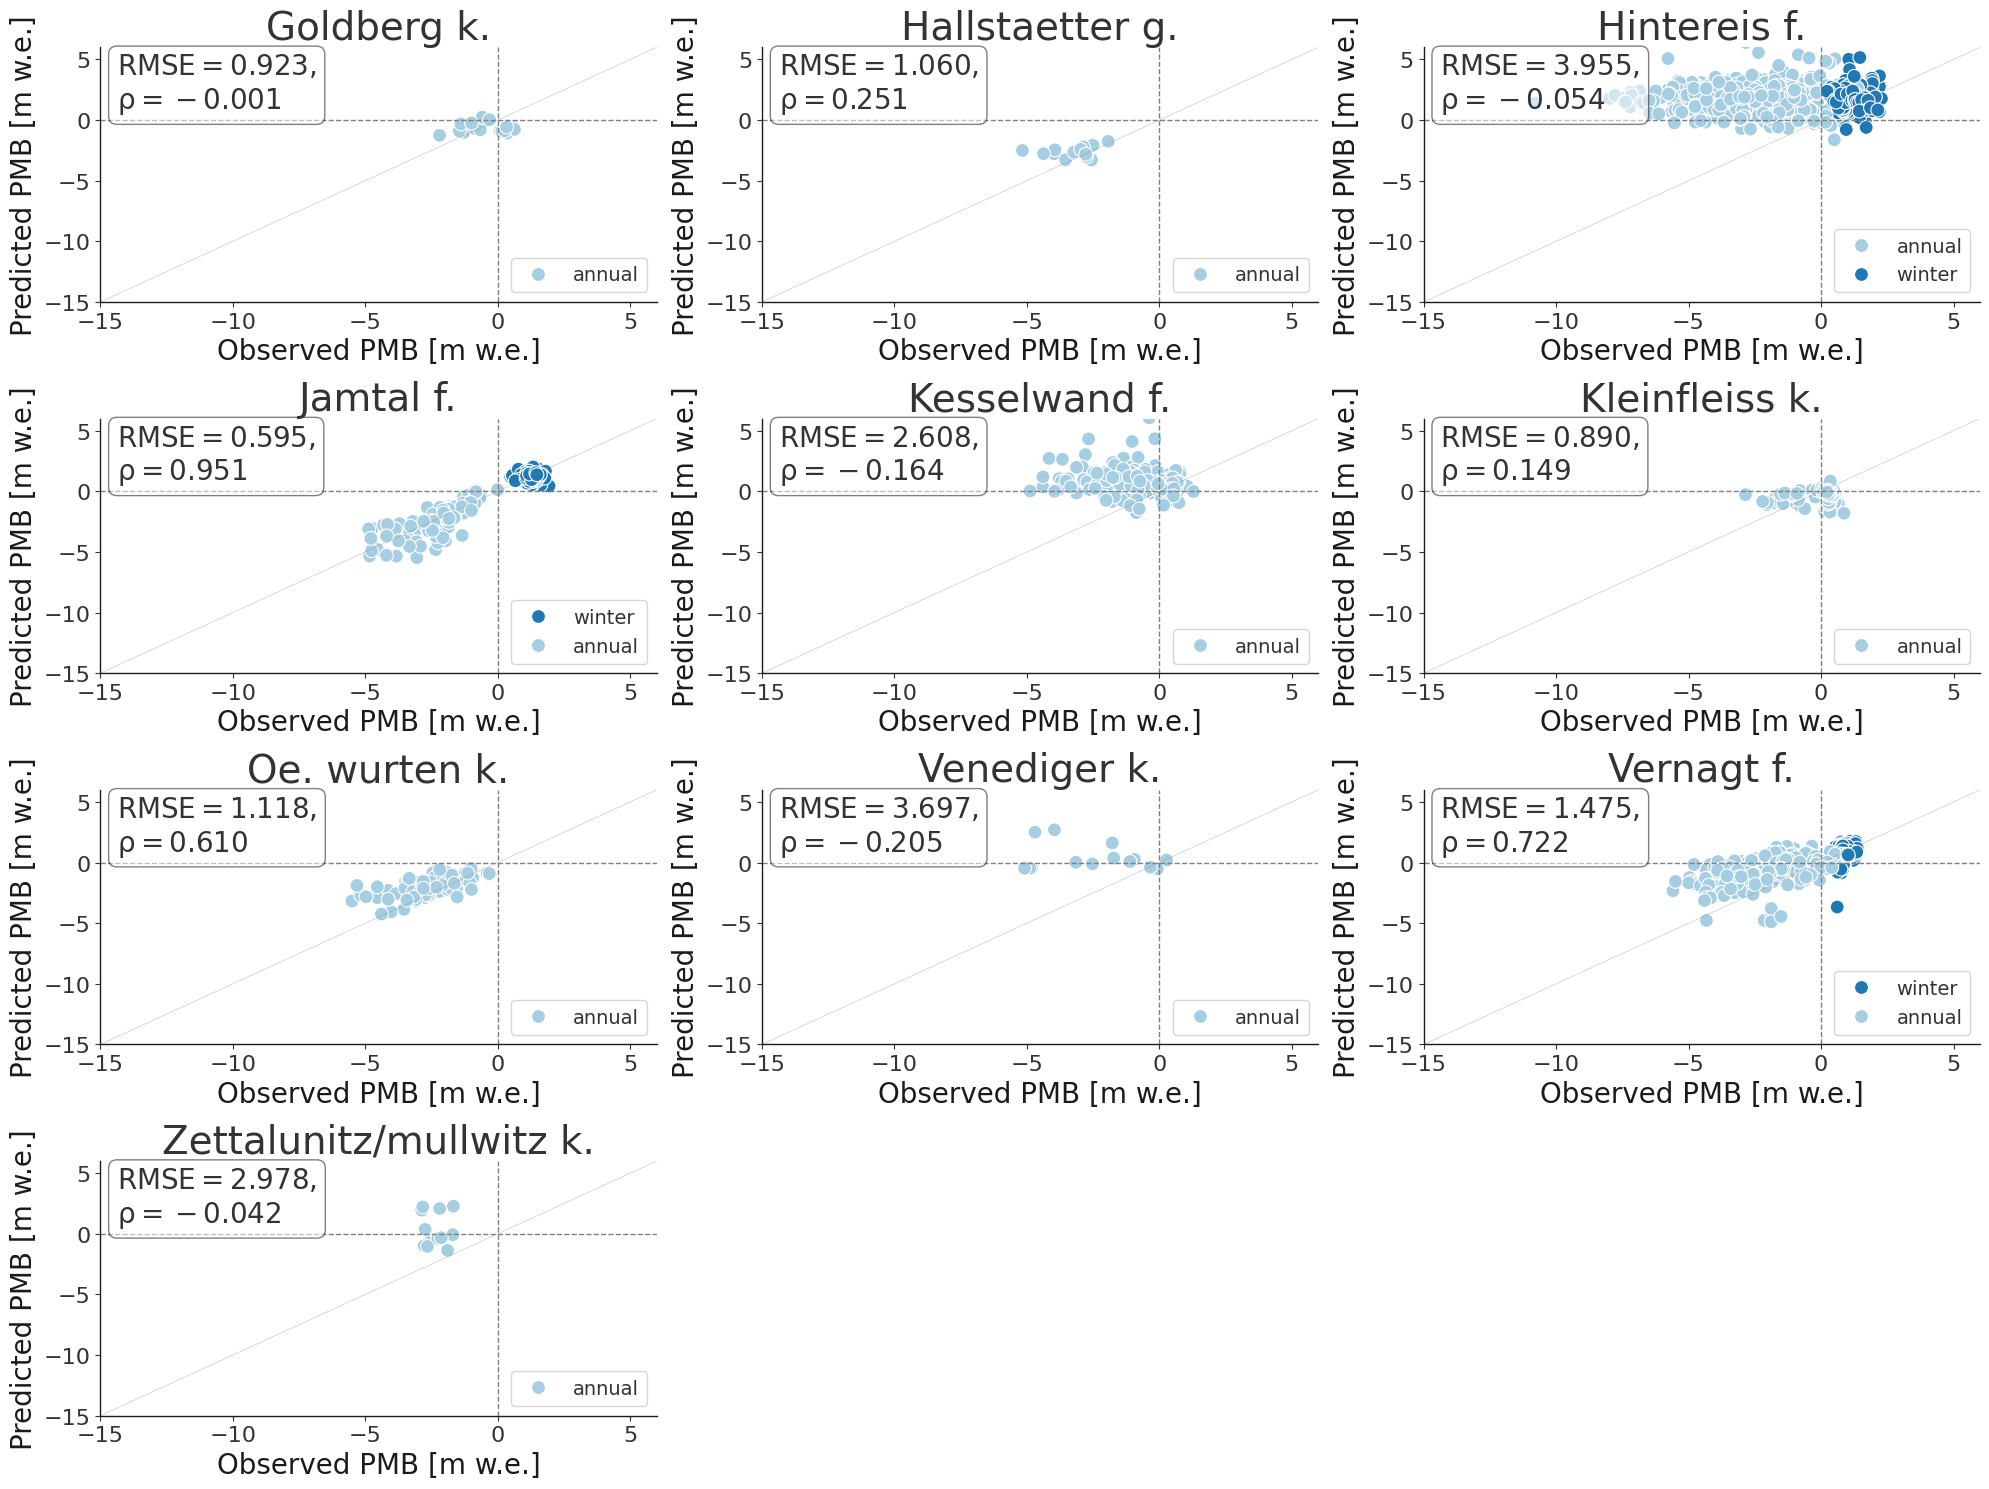

In [21]:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [23]:
display(data_monthly['GLACIER'].unique())

array(['GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
       'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
       'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.', 'CAMPO SETT.', 'CARESER',
       'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE',
       'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GRAND ETRET',
       'LUNGA (VEDRETTA) / LANGENF.', 'LUPO',
       'MALAVALLE (VEDR. DI) / UEBELTALF.',
       'PENDENTE (VEDR.) / HANGENDERF.',
       'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE'],
      dtype=object)

#### Train CH Test IT & AT

In [11]:
display(df['GLACIER'].unique())

# Remove summer stakes
dataloader_gl.data = dataloader_gl.data[dataloader_gl.data['PERIOD'] != 'summer']
dataloader_gl.data = dataloader_gl.data.reset_index(drop=True)
data_monthly = dataloader_gl.data

display(dataloader_gl.data['PERIOD'].unique())
display(data_monthly['PERIOD'].unique())

array(['GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
       'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
       'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.', 'CAMPO SETT.', 'CARESER',
       'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE',
       'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GRAND ETRET',
       'LUNGA (VEDRETTA) / LANGENF.', 'LUPO',
       'MALAVALLE (VEDR. DI) / UEBELTALF.',
       'PENDENTE (VEDR.) / HANGENDERF.',
       'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE'],
      dtype=object)

array(['annual', 'winter'], dtype=object)

array(['annual', 'winter'], dtype=object)

###### Load CH galciers and merge with IT_AT

In [12]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/GLAMOS/point/csv/CH_wgms_dataset_all.csv')
data_IT_AT = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/DOI-WGMS-FoG-2025-02b/csv/IT_AT_wgms_dataset_all_oggm.csv')

display(data_CH.columns)

display(data_IT_AT.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)
data_CH.rename(columns={
    'aspect_sgi': 'aspect', 
    'slope_sgi': 'slope'
}, inplace=True)

display(data_CH.columns)

# Merge CH with IT_AT
data_IT_AT_CH = pd.concat([data_IT_AT, data_CH], axis=0).reset_index(drop=True)

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'RGIId', 'YEAR',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

In [13]:
display(data_IT_AT_CH['PERIOD'].unique())

array(['annual', 'summer', 'winter'], dtype=object)

In [14]:
data_IT_AT_CH_test = data_IT_AT_CH.copy()

display(data_IT_AT_CH_test.shape)
display(data_IT_AT_CH_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_scratch.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_scratch.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_IT_AT_CH_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_IT_AT_wgms_dataset_monthly_full.csv')
data_monthly_CH_IT_AT = dataloader_gl.data

display(data_monthly_CH_IT_AT.head(2))

(39497, 16)

POINT_ID  POINT_LAT  POINT_LON  POINT_ELEVATION  \
0  GOLDBERG K._2020_43346_AT  47.041127  12.965073           2700.0   
1  GOLDBERG K._2020_43383_AT  47.043262  12.979787           2410.0   

   FROM_DATE   TO_DATE  POINT_BALANCE      GLACIER  PERIOD           RGIId  \
0   20190920  20200922          0.276  GOLDBERG K.  annual  RGI60-11.00289   
1   20190920  20200922         -1.278  GOLDBERG K.  annual  RGI60-11.00289   

   YEAR      aspect      slope    topo  hugonnet_dhdt  consensus_ice_thickness  
0  2020   48.343734   8.445758  2697.0      -1.065098                48.199932  
1  2020  349.177712  16.786407  2421.0      -1.196566                12.570357

2025-05-15 08:31:51,763 - INFO - Number of annual and seasonal samples: 39497
2025-05-15 08:31:51,766 - INFO - Running on 63 glaciers:
['GOLDBERG K.' 'HALLSTAETTER G.' 'HINTEREIS F.' 'JAMTAL F.'
 'KESSELWAND F.' 'KLEINFLEISS K.' 'OE. WURTEN K.' 'VENEDIGER K.'
 'VERNAGT F.' 'ZETTALUNITZ/MULLWITZ K.' 'CAMPO SETT.' 'CARESER'
 'CARESER CENTRALE' 'CARESER OCCIDENTALE' 'CARESER ORIENTALE' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'GRAND ETRET'
 'LUNGA (VEDRETTA) / LANGENF.' 'LUPO' 'MALAVALLE (VEDR. DI) / UEBELTALF.'
 'PENDENTE (VEDR.) / HANGENDERF.' 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.'
 'SURETTA MERIDIONALE' 'adler' 'albigna' 'aletsch' 'allalin' 'basodino'
 'cantun' 'chessjen' 'clariden' 'corbassiere' 'corvatsch' 'damma'
 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern'
 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pizol' 'plainemorte'
 'plattalva' 'rhone' 'sanktanna' 'sardona' 'schwarzbach' 'schwarzberg'
 'sexrouge' 'silvretta' 'taelliboden' 'tiefen' 'tortin' 't

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2020  12.965073  47.041127          0.276       2005.391746   
1  2020  12.965073  47.041127          0.276       2005.391746   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            694.608254           2700.0  RGI60-11.00289   
1            694.608254           2700.0  RGI60-11.00289   

                    POINT_ID  ID  ...  consensus_ice_thickness       t2m  \
0  GOLDBERG K._2020_43346_AT   0  ...                48.199932  4.488969   
1  GOLDBERG K._2020_43346_AT   0  ...                48.199932 -2.252254   

         tp          slhf          sshf          ssrd       fal           str  \
0  0.003263 -2.294197e+06 -1.238352e+06  9.166772e+06  0.229960 -3.531357e+06   
1  0.011190 -3.506452e+05 -2.978029e+05  5.373250e+06  0.610373 -2.029104e+06   

        u10       v10  
0  0.265244  0.430310  
1  0.098150  0.601325  

[2 rows x 27 columns]

In [15]:
# Remove summer stakes
dataloader_gl.data = dataloader_gl.data[dataloader_gl.data['PERIOD'] != 'summer']
dataloader_gl.data = dataloader_gl.data.reset_index(drop=True)
data_monthly_CH_IT_AT = dataloader_gl.data

display(dataloader_gl.data['PERIOD'].unique())
display(data_monthly_CH_IT_AT['PERIOD'].unique())

array(['annual', 'winter'], dtype=object)

array(['annual', 'winter'], dtype=object)

In [16]:
test_glaciers = [
    'GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
    'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
    'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.', 'CAMPO SETT.', 'CARESER',
    'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE',
    'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GRAND ETRET',
    'LUNGA (VEDRETTA) / LANGENF.', 'LUPO',
    'MALAVALLE (VEDR. DI) / UEBELTALF.',
    'PENDENTE (VEDR.) / HANGENDERF.',
    'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 48734
Size of train data: 301118
Percentage of test size: 16.18%
Train:
Number of winter and annual samples: 301118
Number of annual samples: 93904
Number of winter samples: 207214
Test:
Number of winter and annual samples: 48734
Number of annual samples: 35814
Number of winter samples: 12920
Total:
Number of monthly rows: 349852
Number of annual rows: 129718
Number of winter rows: 220134


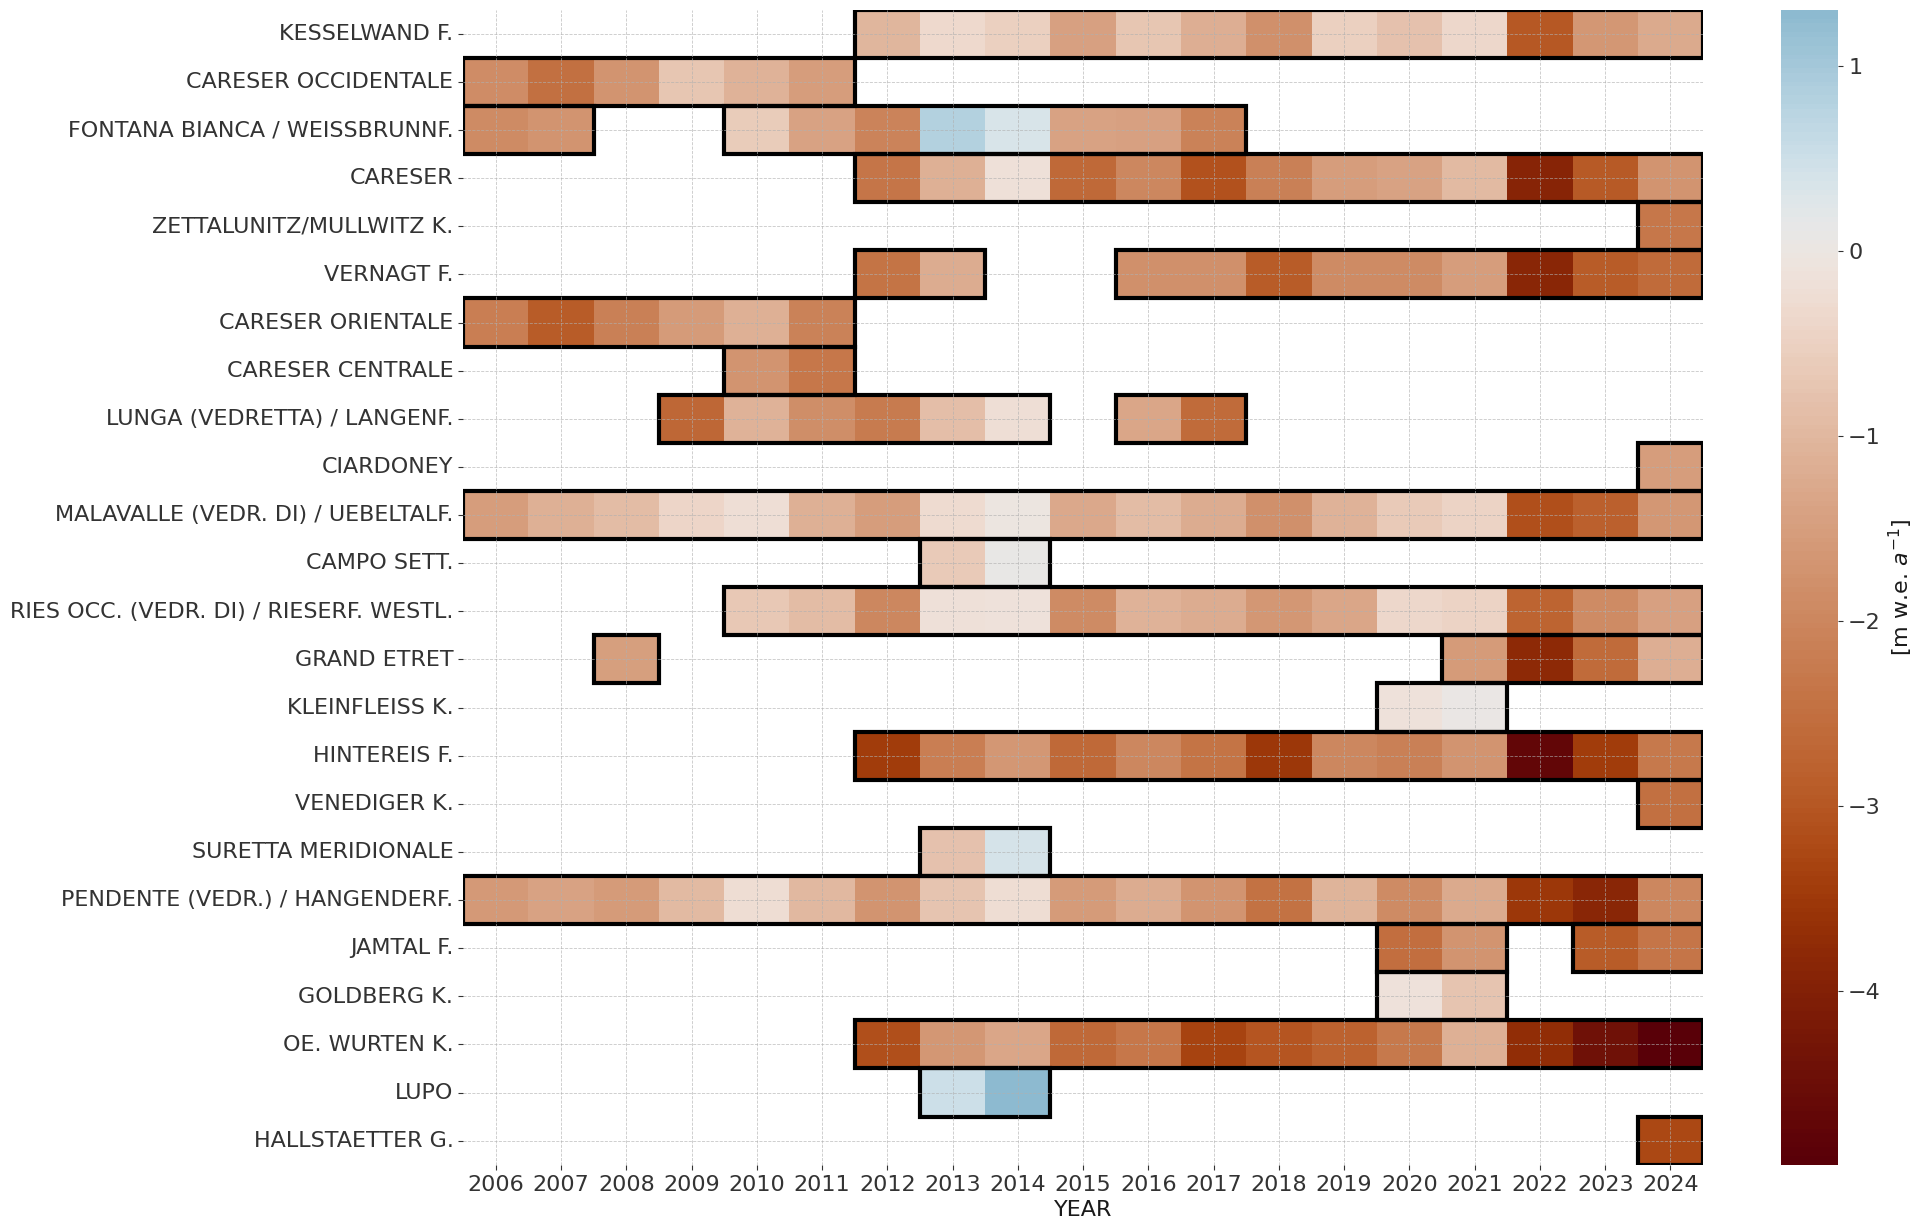

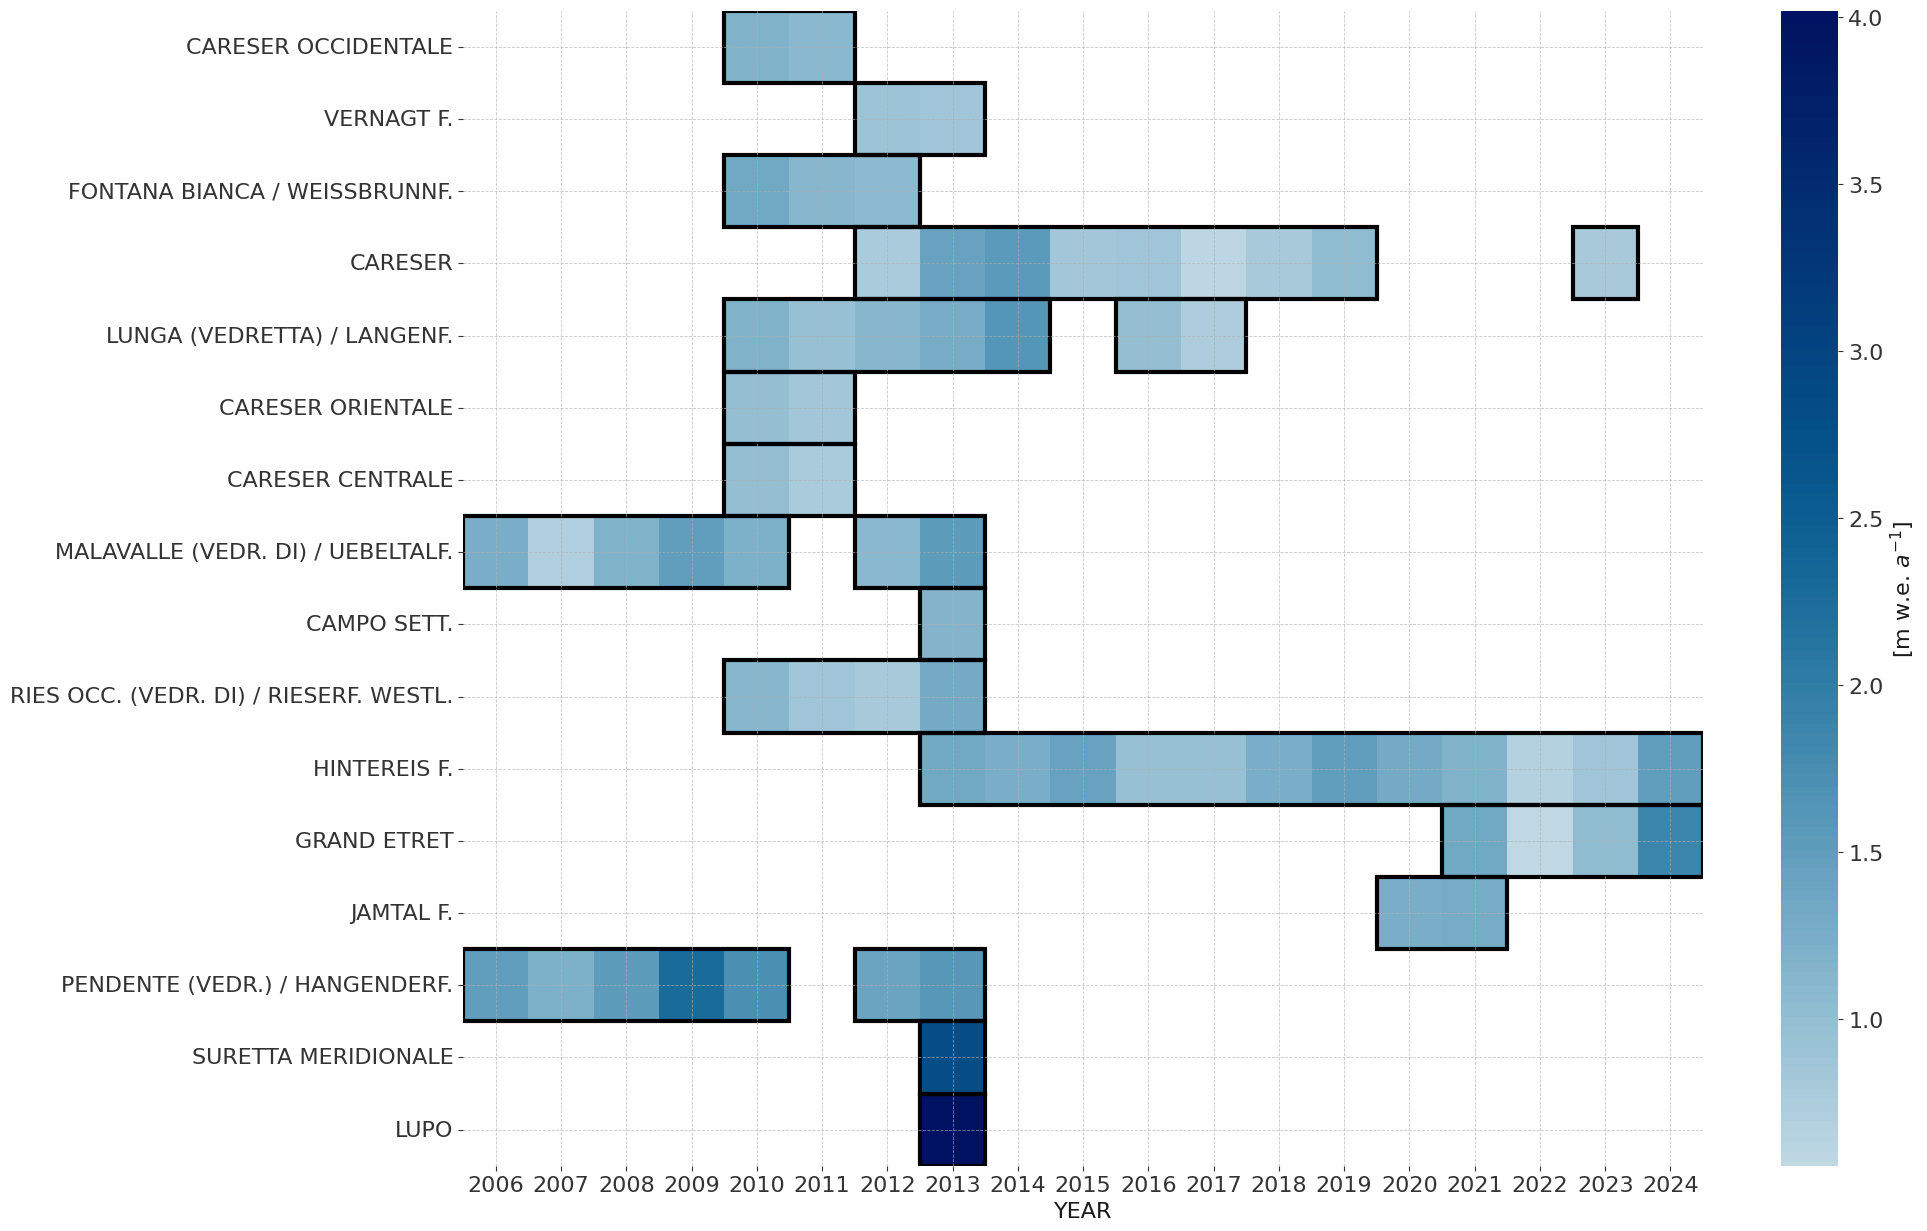

In [17]:
plotHeatmap(test_glaciers, data_monthly, period='annual')

plotHeatmap(test_glaciers, data_monthly, period='winter')

Test glaciers: (24) ['GOLDBERG K.' 'HALLSTAETTER G.' 'HINTEREIS F.' 'JAMTAL F.'
 'KESSELWAND F.' 'KLEINFLEISS K.' 'OE. WURTEN K.' 'VENEDIGER K.'
 'VERNAGT F.' 'ZETTALUNITZ/MULLWITZ K.' 'CAMPO SETT.' 'CARESER'
 'CARESER CENTRALE' 'CARESER OCCIDENTALE' 'CARESER ORIENTALE' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'GRAND ETRET'
 'LUNGA (VEDRETTA) / LANGENF.' 'LUPO' 'MALAVALLE (VEDR. DI) / UEBELTALF.'
 'PENDENTE (VEDR.) / HANGENDERF.' 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.'
 'SURETTA MERIDIONALE']
Percentage of test size: 16.18%
Size of test set: 48734
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']

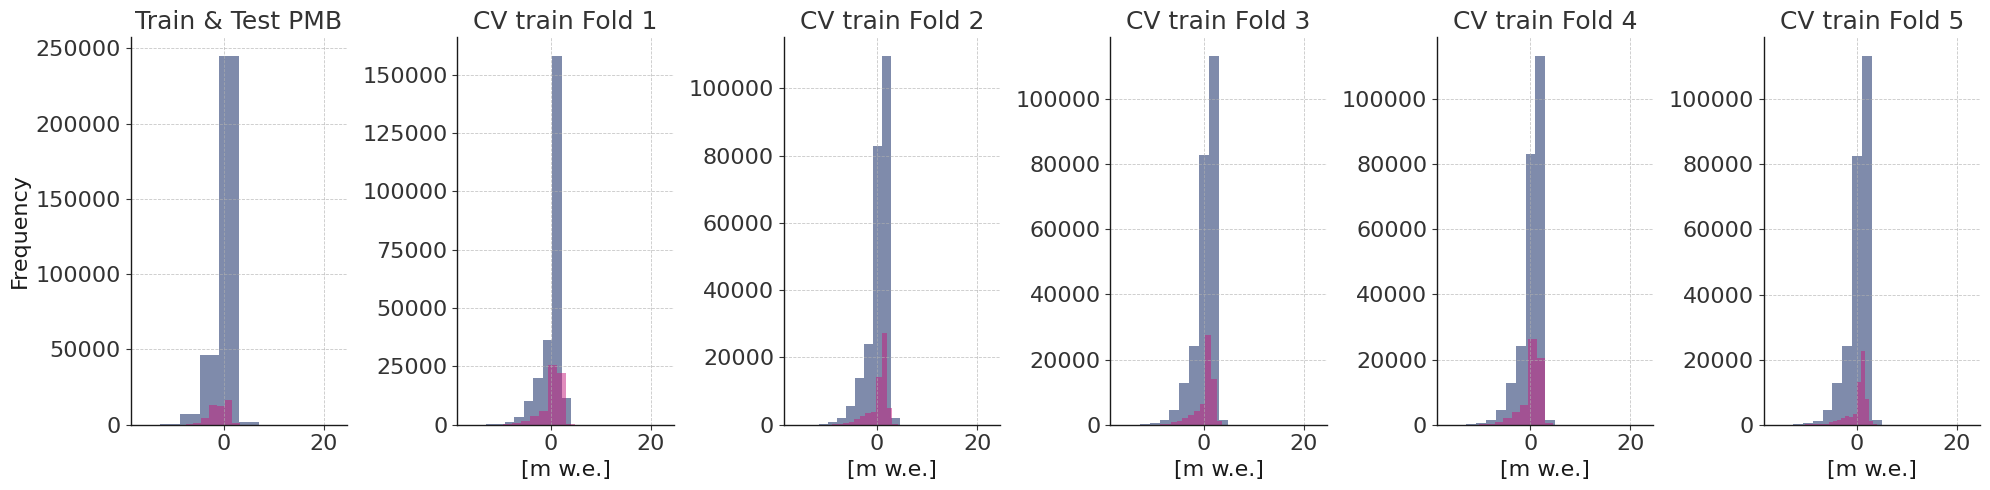

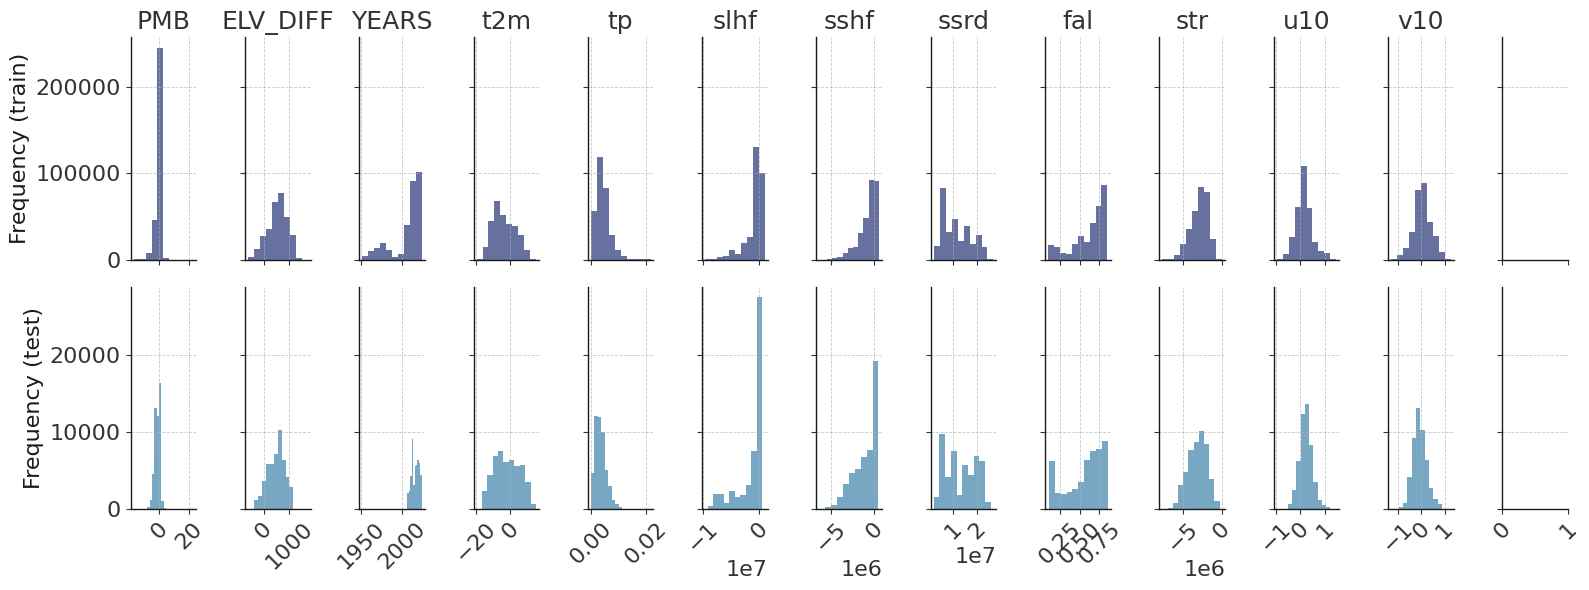

In [18]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

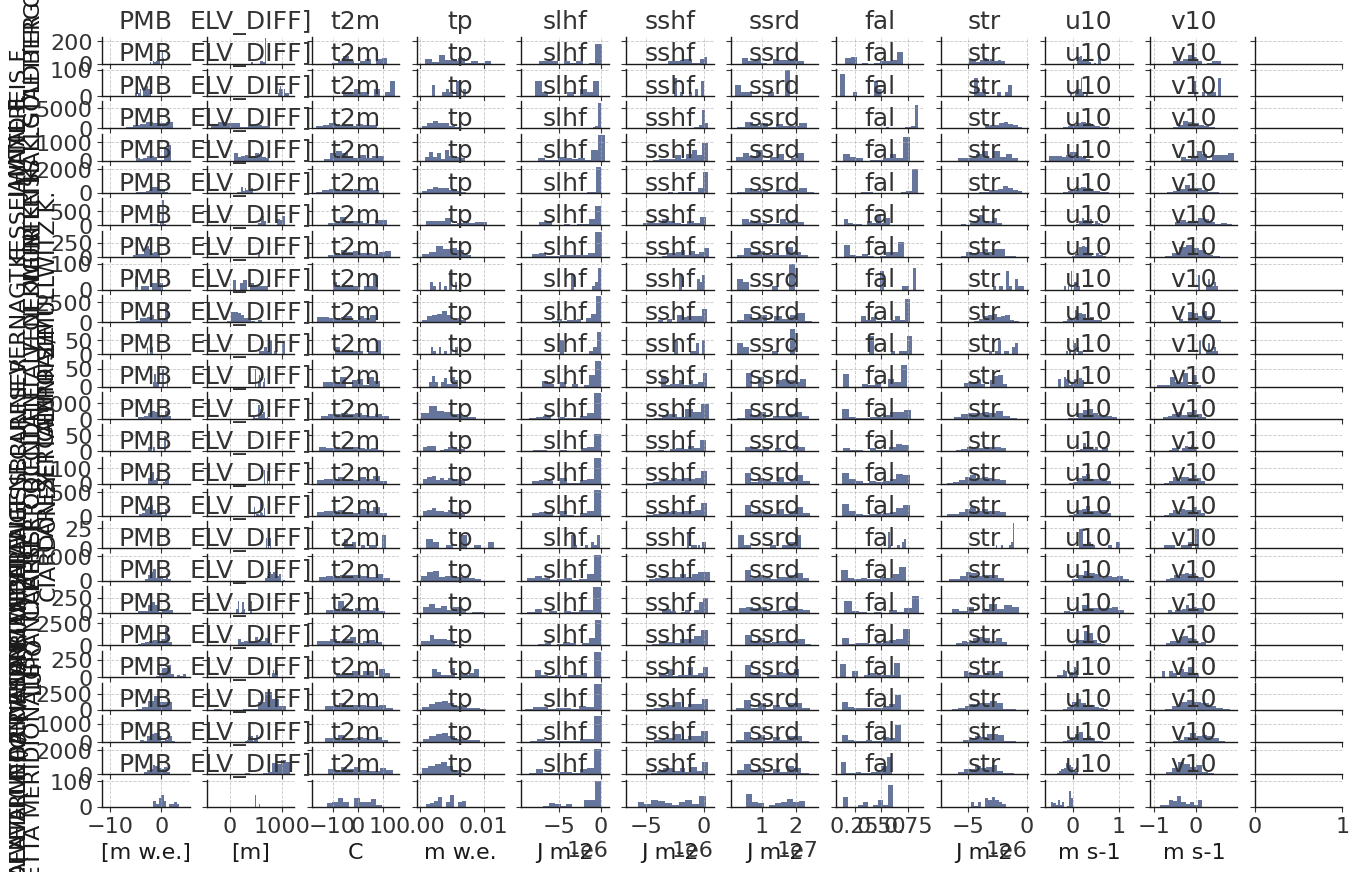

In [49]:
## This code takes forever to execute
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

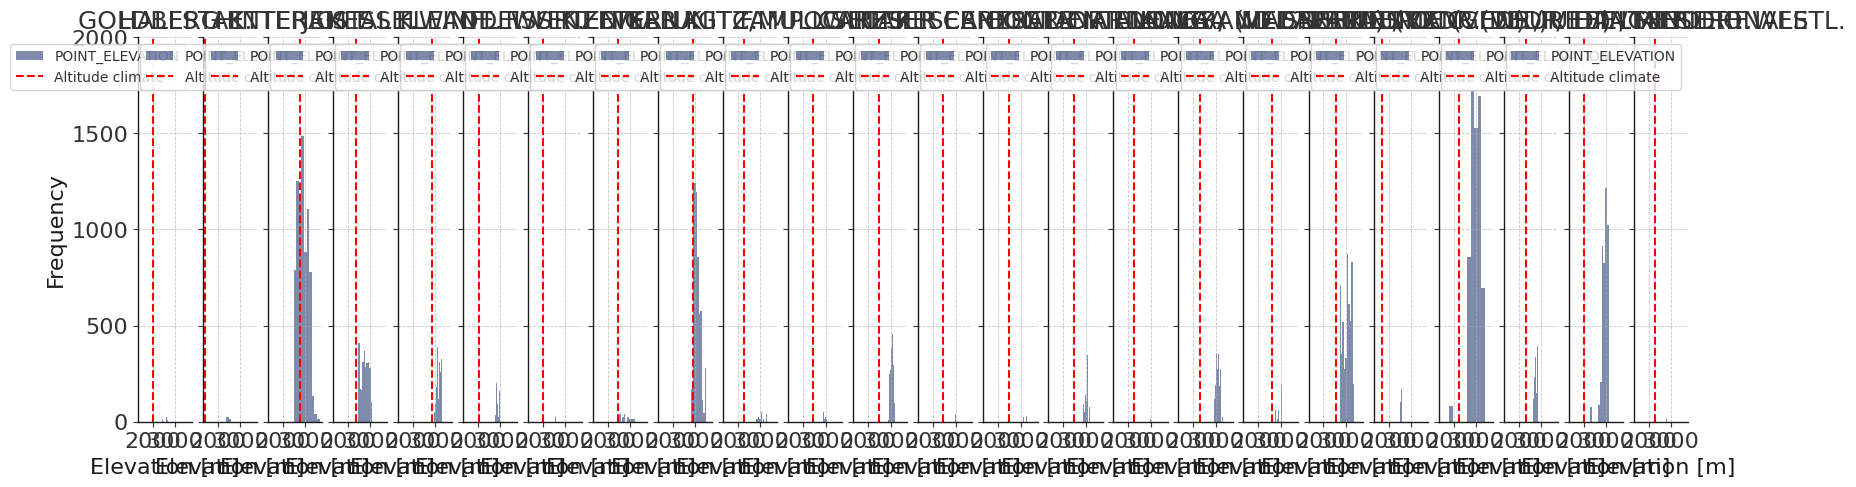

In [20]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

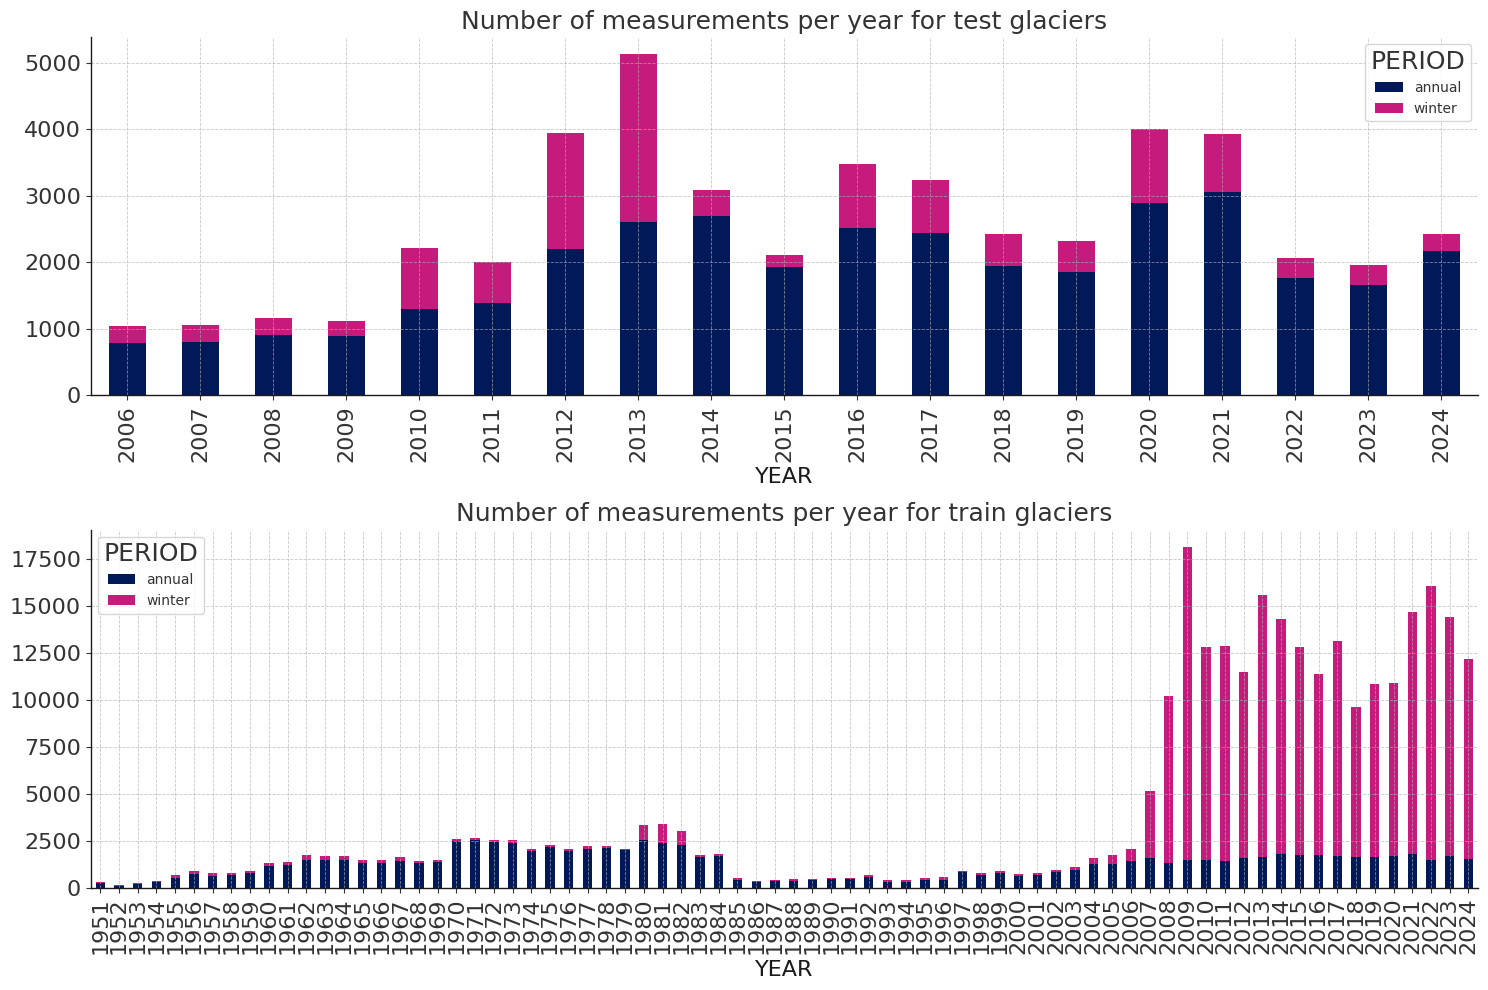

In [21]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

#### XGBoost

In [22]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

#### Grid Search

In [24]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_train_IT_AT_test.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'CH_train_IT_AT_test.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (301118, 25)
Shape of testing dataset: (48734, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.21190582278257802
Shape of the test: (48734, 14)
Overall score: 1.4499405070478792
CPU times: user 4.8 s, sys: 133 ms, total: 4.94 s
Wall time: 616 ms


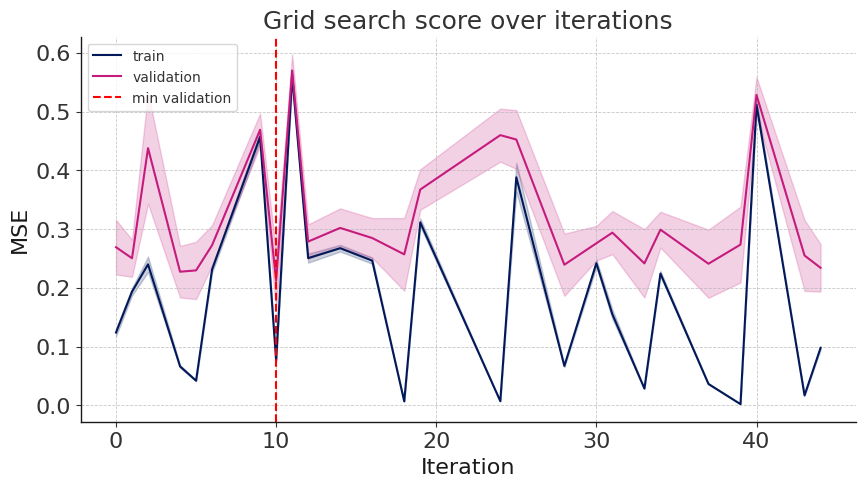

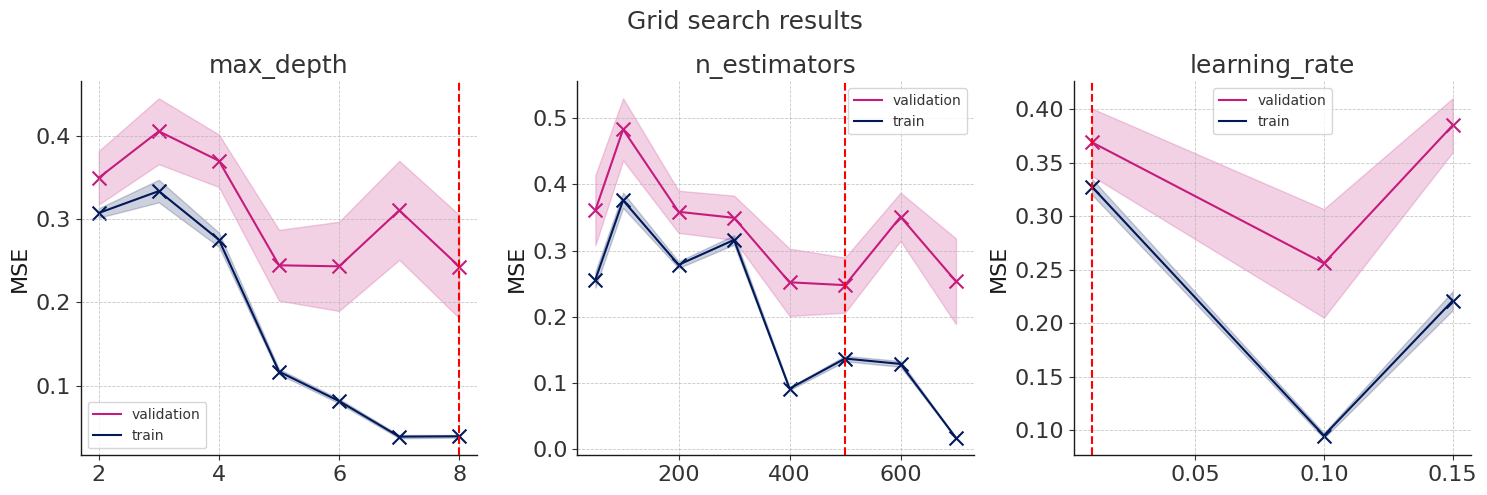

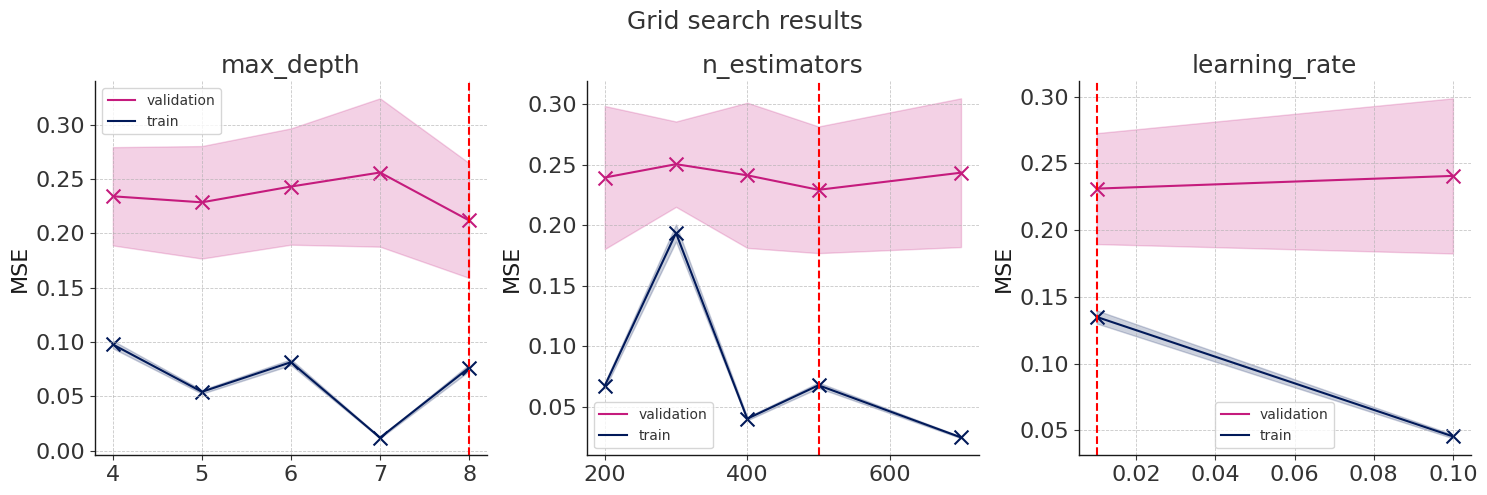

In [25]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

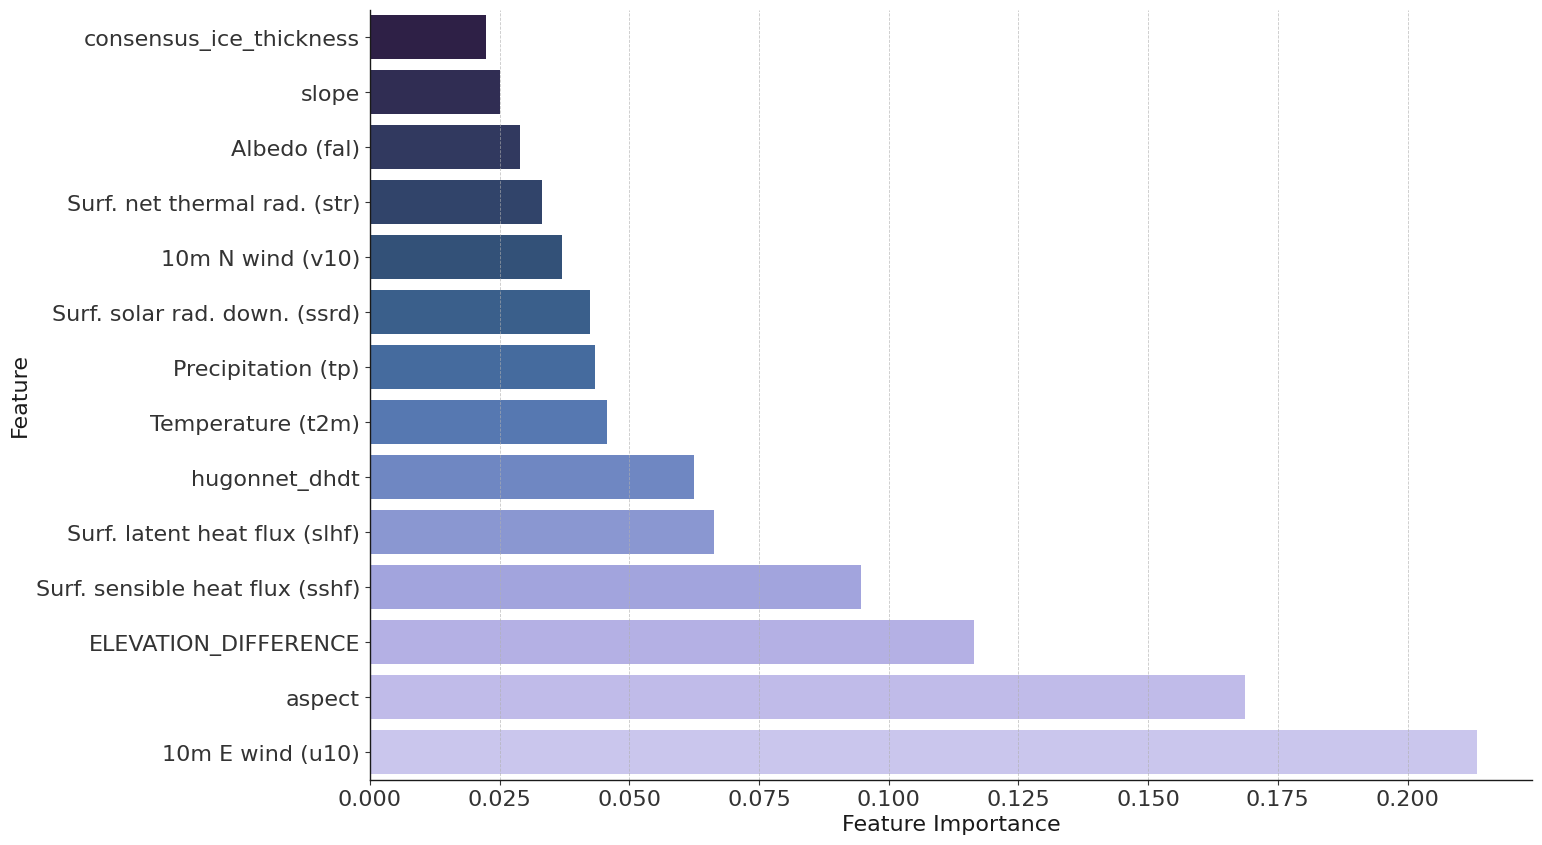

In [26]:
FIPlot(best_estimator, feature_columns, vois_climate)

Shape of the test: (48734, 14)
{'GOLDBERG K.': '#a6cee3', 'HALLSTAETTER G.': '#1f78b4', 'HINTEREIS F.': '#b2df8a', 'JAMTAL F.': '#33a02c', 'KESSELWAND F.': '#fb9a99', 'KLEINFLEISS K.': '#e31a1c', 'OE. WURTEN K.': '#fdbf6f', 'VENEDIGER K.': '#ff7f00', 'VERNAGT F.': '#cab2d6', 'ZETTALUNITZ/MULLWITZ K.': '#6a3d9a', 'CAMPO SETT.': '#ffff99', 'CARESER': '#b15928', 'CARESER CENTRALE': '#8dd3c7', 'CARESER OCCIDENTALE': '#ffffb3', 'CARESER ORIENTALE': '#bebada', 'CIARDONEY': '#fb8072', 'FONTANA BIANCA / WEISSBRUNNF.': '#80b1d3', 'GRAND ETRET': '#fdb462', 'LUNGA (VEDRETTA) / LANGENF.': '#b3de69', 'LUPO': '#fccde5', 'MALAVALLE (VEDR. DI) / UEBELTALF.': '#d9d9d9', 'PENDENTE (VEDR.) / HANGENDERF.': '#bc80bd', 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.': '#ccebc5', 'SURETTA MERIDIONALE': '#ffed6f'}


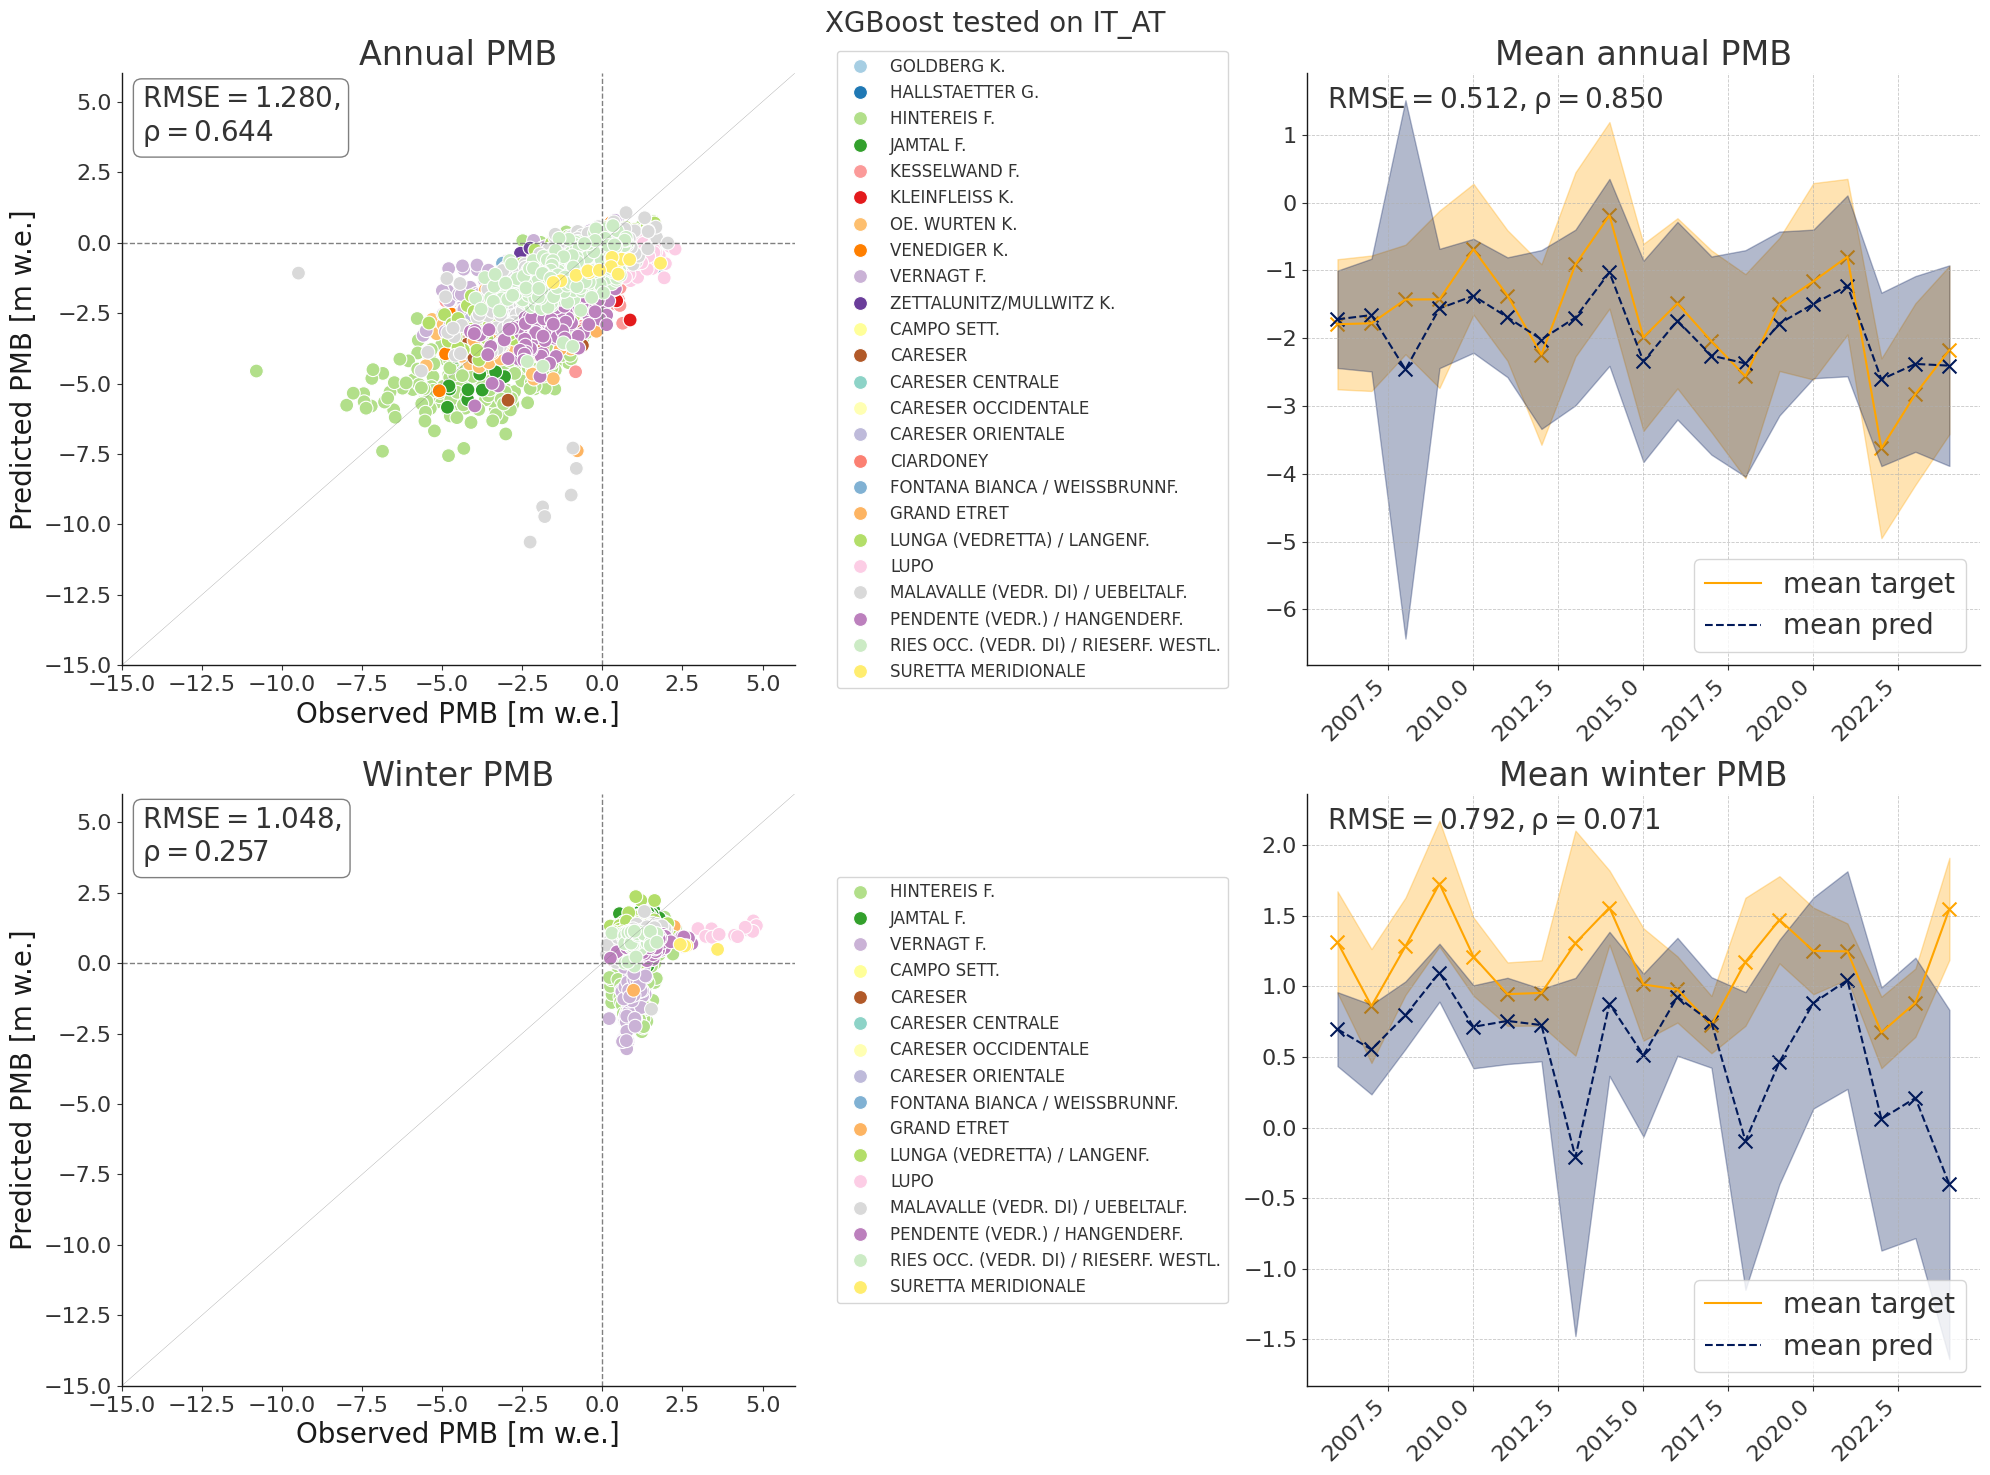

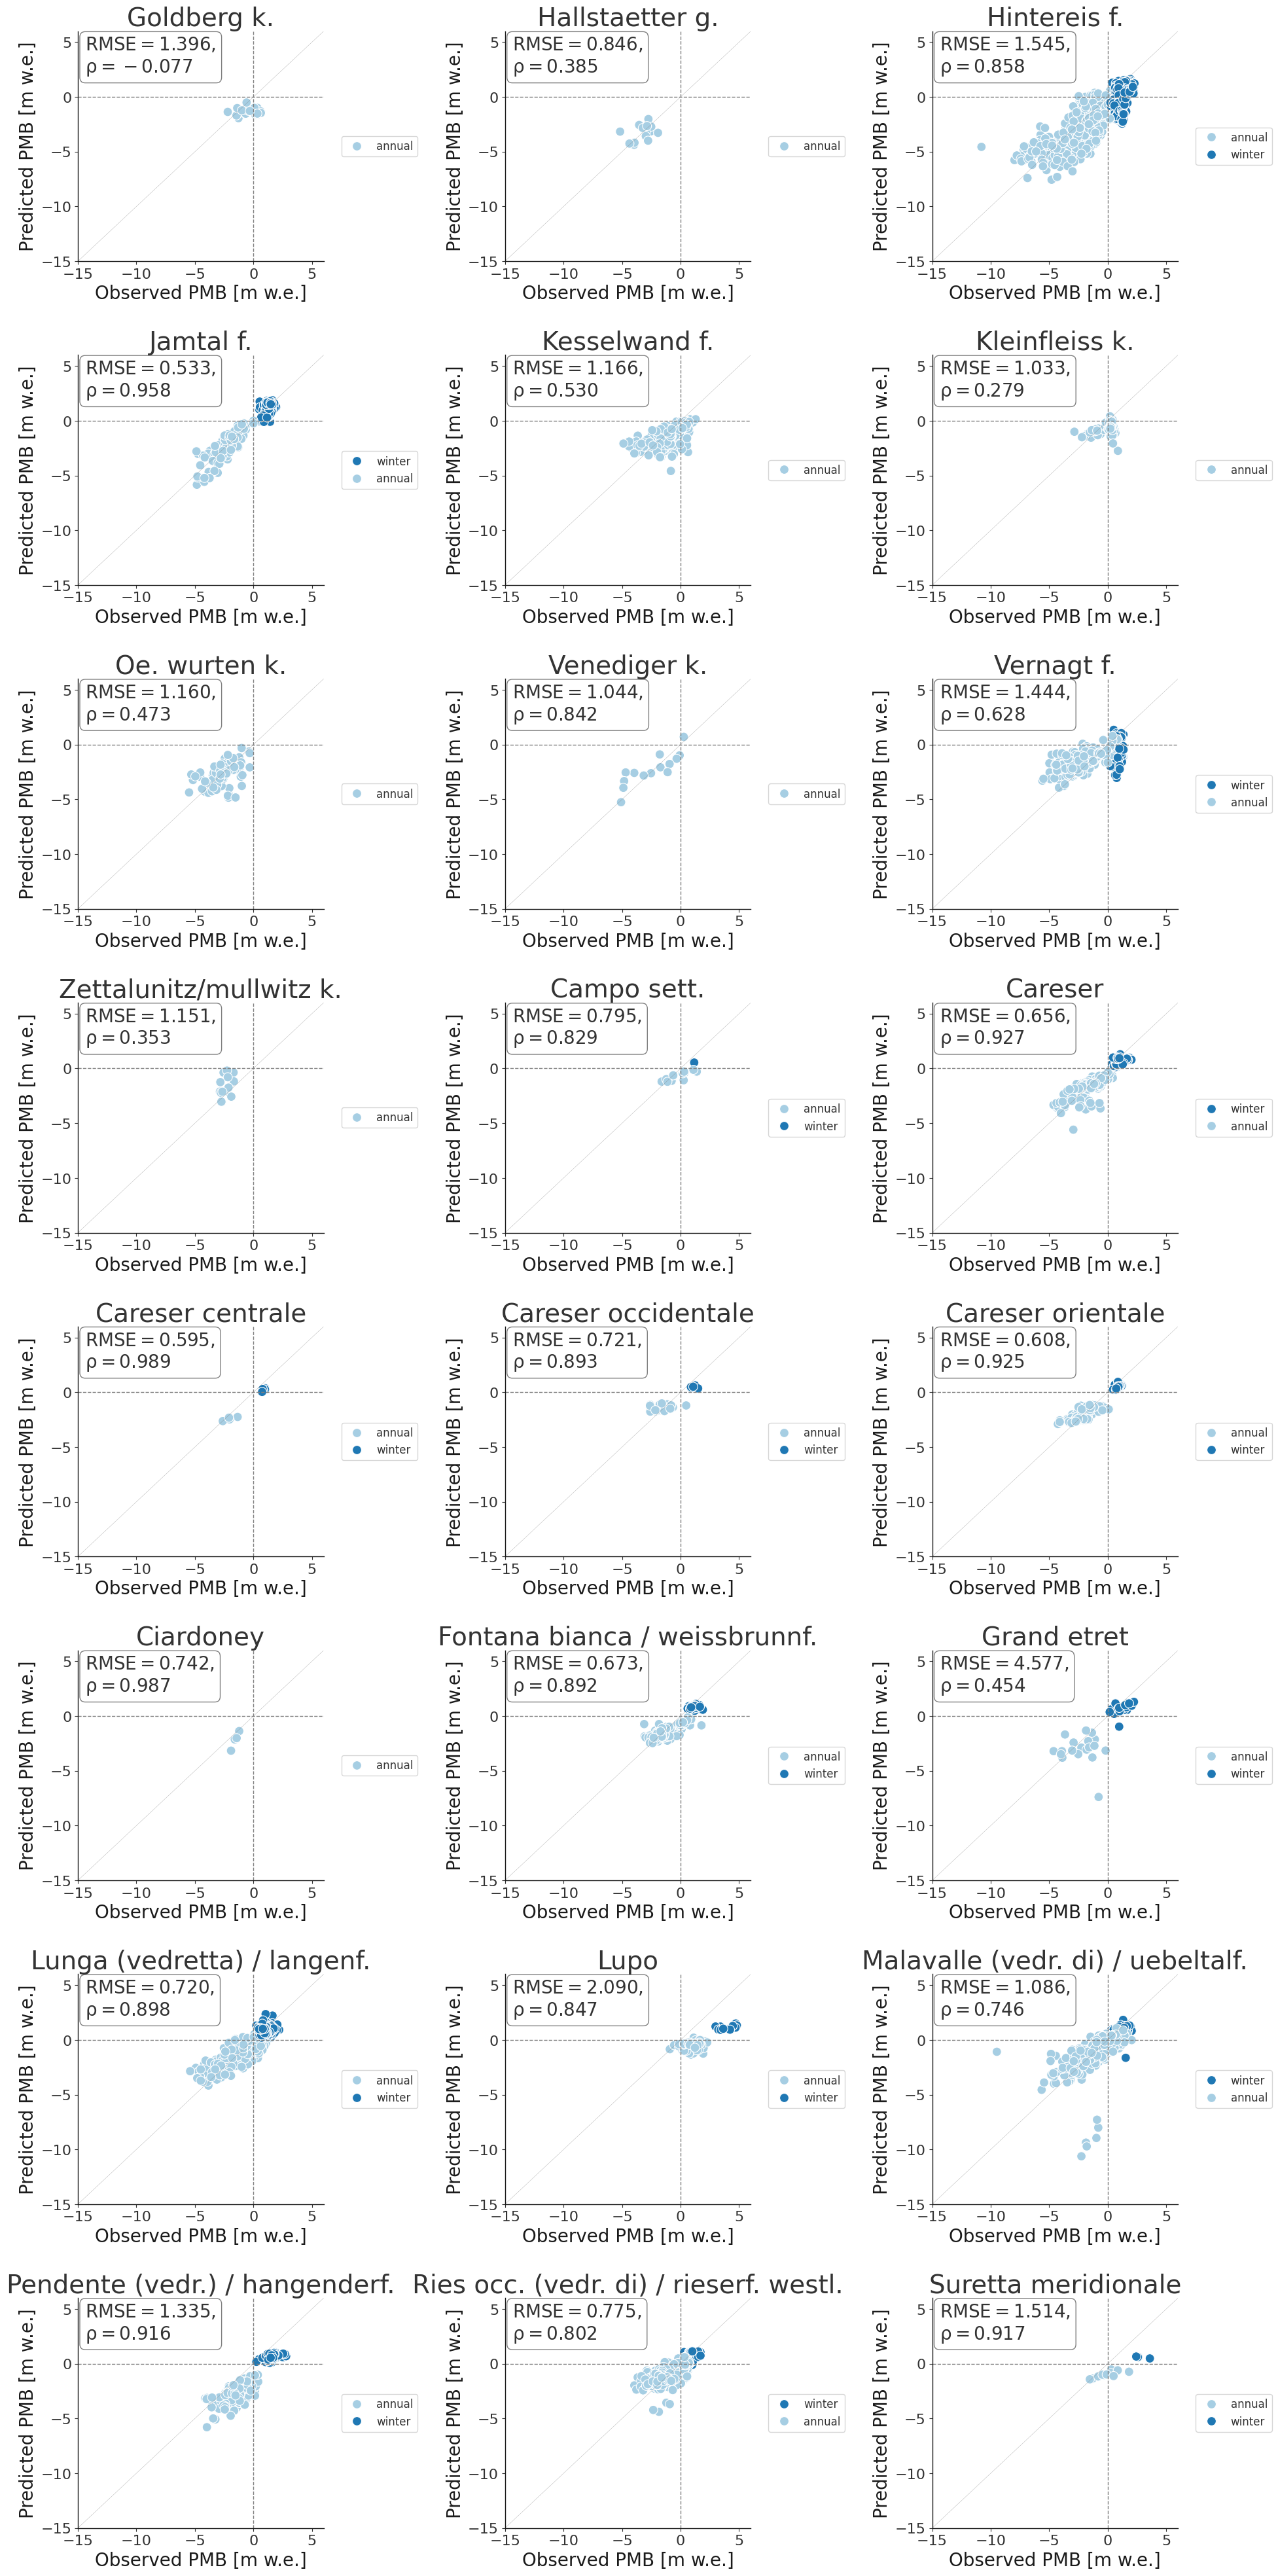

In [33]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on IT_AT', fontsize=20)
plt.tight_layout()

PlotIndividualGlacierPredVsTruth(grouped_ids)

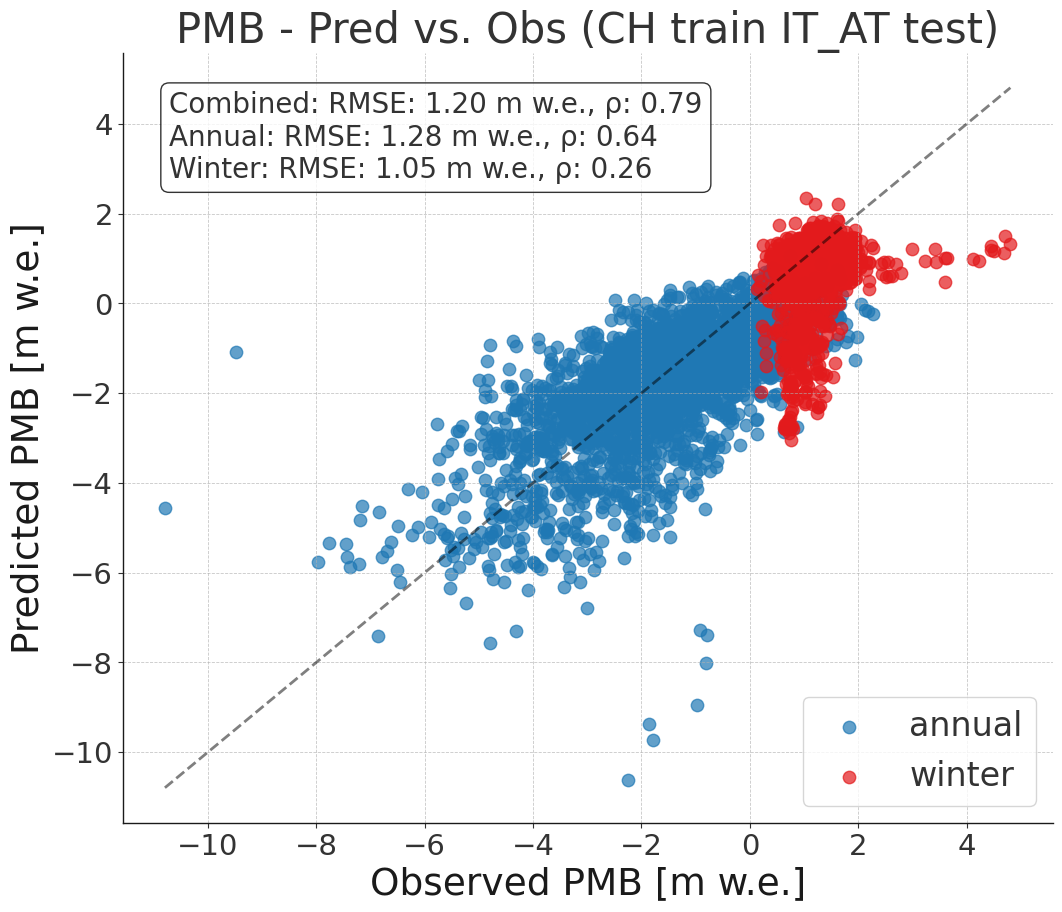

In [44]:
filtered_grouped_ids = grouped_ids[grouped_ids['pred'] >= -15].copy()

PlotPredictionsCombined(filtered_grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH train IT_AT test')

In [48]:
display(grouped_ids[grouped_ids['target'] < -9])
display(data_monthly_CH_IT_AT[data_monthly_CH_IT_AT['POINT_ID']=='MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT'])
display(data_monthly_CH_IT_AT[data_monthly_CH_IT_AT['POINT_ID']=='HINTEREIS F._2018_15865_AT'])

# Get the specific stakes with extreme predictions
outlier_stakes = data_monthly_CH_IT_AT[(data_monthly_CH_IT_AT['GLACIER'] == 'GRAND ETRET') & 
                                       (data_monthly_CH_IT_AT['POINT_ID'].isin(['GRAND ETRET_2008_32398_IT', 
                                                                               'GRAND ETRET_2008_32396_IT']))]

# Display the outlier stakes data
display(outlier_stakes)

# Get all stakes from the same glacier for comparison
normal_stakes = data_monthly_CH_IT_AT[(data_monthly_CH_IT_AT['GLACIER'] == 'GRAND ETRET') & 
                                    (~data_monthly_CH_IT_AT['POINT_ID'].isin(['GRAND ETRET_2008_32398_IT', 
                                                                            'GRAND ETRET_2008_32396_IT']))]

display(normal_stakes['POINT_ID'].unique())

comparison_columns = ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 
                      'ssrd', 'fal', 'str', 'aspect', 'slope', 'hugonnet_dhdt', 
                      'consensus_ice_thickness', 'ALTITUDE_CLIMATE', 
                      'POINT_ELEVATION', 'POINT_BALANCE']

# Display statistics for outlier stakes
print("=== Outlier Stakes Statistics ===")
display(outlier_stakes[comparison_columns].describe())

# Display statistics for normal stakes
print("=== Normal Stakes Statistics ===")
display(normal_stakes[comparison_columns].describe())

# Check for extreme values in any of the features
for col in comparison_columns:
    if col in outlier_stakes.columns:
        outlier_values = outlier_stakes[col].values
        normal_range = normal_stakes[col].quantile([0.05, 0.95]).values
        
        if (outlier_values < normal_range[0]).any() or (outlier_values > normal_range[1]).any():
            print(f"Potential issue in {col}: Outliers outside 5-95% range of normal stakes")
            print(f"Outlier values: {outlier_values}")
            print(f"Normal range (5-95%): {normal_range}")
            print("---")

target  YEAR                                         POINT_ID      pred  \
ID                                                                              
357  -10.793  2018                       HINTEREIS F._2018_15865_AT -4.557533   
4236  -9.480  2023  MALAVALLE (VEDR. DI) / UEBELTALF._2023_63204_IT -1.084392   

      PERIOD                            GLACIER  
ID                                               
357   annual                       HINTEREIS F.  
4236  annual  MALAVALLE (VEDR. DI) / UEBELTALF.

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
39848  2018    11.1883    46.9486         -2.253       2106.907077   
39849  2018    11.1883    46.9486         -2.253       2106.907077   
39850  2018    11.1883    46.9486         -2.253       2106.907077   
39851  2018    11.1883    46.9486         -2.253       2106.907077   
39852  2018    11.1883    46.9486         -2.253       2106.907077   
39853  2018    11.1883    46.9486         -2.253       2106.907077   
39854  2018    11.1883    46.9486         -2.253       2106.907077   
39855  2018    11.1883    46.9486         -2.253       2106.907077   
39856  2018    11.1883    46.9486         -2.253       2106.907077   
39857  2018    11.1883    46.9486         -2.253       2106.907077   
39858  2018    11.1883    46.9486         -2.253       2106.907077   
39859  2018    11.1883    46.9486         -2.253       2106.907077   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
39848           -294.907077           1812.0  RGI60-11.00597   
39849           -294.907077           1812.0  RGI60-11.00597   
39850           -294.907077           1812.0  RGI60-11.00597   
39851           -294.907077           1812.0  RGI60-11.00597   
39852           -294.907077           1812.0  RGI60-11.00597   
39853           -294.907077           1812.0  RGI60-11.00597   
39854           -294.907077           1812.0  RGI60-11.00597   
39855           -294.907077           1812.0  RGI60-11.00597   
39856           -294.907077           1812.0  RGI60-11.00597   
39857           -294.907077           1812.0  RGI60-11.00597   
39858           -294.907077           1812.0  RGI60-11.00597   
39859           -294.907077           1812.0  RGI60-11.00597   

                                              POINT_ID    ID  ...  \
39848  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39849  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39850  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39851  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39852  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39853  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39854  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39855  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39856  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39857  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39858  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   
39859  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  4111  ...   

       consensus_ice_thickness        t2m        tp          slhf  \
39848                127.05397   3.514362  0.002408 -2.504375e+06   
39849                127.05397  -5.065515  0.003797 -2.462680e+05   
39850                127.05397  -9.616712  0.004760  1.031587e+05   
39851                127.05397  -6.673958  0.004374  1.453840e+05   
39852                127.05397 -10.268722  0.001854 -5.791443e+04   
39853                127.05397  -4.859537  0.003724 -1.345368e+05   
39854                127.05397   2.418591  0.001960 -2.828000e+05   
39855                127.05397   5.931570  0.004013 -1.894243e+06   
39856                127.05397   9.983726  0.004075 -7.965204e+06   
39857                127.05397  11.945057  0.005752 -8.387458e+06   
39858                127.05397  12.086666  0.007084 -7.105278e+06   
39859                127.05397   9.203737  0.003074 -5.581370e+06   

               sshf          ssrd       fal           str       u10       v10  
39848 -7.261793e+05  1.071013e+07  0.255283 -4.841523e+06  0.449957 -0.413080  
39849 -1.746645e+04  6.463969e+06  0.606410 -2.668151e+06  0.421212 -0.369625  
39850  2.278279e+05  5.082473e+06  0.650191 -2.375438e+06  0.568277 -0.353116  
39851  6.455228e+04  5.949111e+06  0.652908 -2.545297e+06  0.508004 -0.137401  
39852 -7.523339e+05  9.678377e+06  0.639882 -3.391534e+06  0.214986

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
4378  2018  10.789539  46.813913        -10.793       2835.655296   
4379  2018  10.789539  46.813913        -10.793       2835.655296   
4380  2018  10.789539  46.813913        -10.793       2835.655296   
4381  2018  10.789539  46.813913        -10.793       2835.655296   
4382  2018  10.789539  46.813913        -10.793       2835.655296   
4383  2018  10.789539  46.813913        -10.793       2835.655296   
4384  2018  10.789539  46.813913        -10.793       2835.655296   
4385  2018  10.789539  46.813913        -10.793       2835.655296   
4386  2018  10.789539  46.813913        -10.793       2835.655296   
4387  2018  10.789539  46.813913        -10.793       2835.655296   
4388  2018  10.789539  46.813913        -10.793       2835.655296   
4389  2018  10.789539  46.813913        -10.793       2835.655296   
4390  2018  10.789539  46.813913        -10.793       2835.655296   

      ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
4378           -332.655296           2503.0  RGI60-11.00897   
4379           -332.655296           2503.0  RGI60-11.00897   
4380           -332.655296           2503.0  RGI60-11.00897   
4381           -332.655296           2503.0  RGI60-11.00897   
4382           -332.655296           2503.0  RGI60-11.00897   
4383           -332.655296           2503.0  RGI60-11.00897   
4384           -332.655296           2503.0  RGI60-11.00897   
4385           -332.655296           2503.0  RGI60-11.00897   
4386           -332.655296           2503.0  RGI60-11.00897   
4387           -332.655296           2503.0  RGI60-11.00897   
4388           -332.655296           2503.0  RGI60-11.00897   
4389           -332.655296           2503.0  RGI60-11.00897   
4390           -332.655296           2503.0  RGI60-11.00897   

                        POINT_ID   ID  ...  consensus_ice_thickness  \
4378  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4379  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4380  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4381  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4382  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4383  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4384  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4385  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4386  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4387  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4388  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4389  HINTEREIS F._2018_15865_AT  357  ...               115.586075   
4390  HINTEREIS F._2018_15865_AT  357  ...               115.586075   

            t2m        tp           slhf           sshf          ssrd  \
4378   4.084587  0.002613    3288.603299   54395.162102  1.540689e+07   
4379  -1.138309  0.001870  -13316.871195  120162.499779  1.120831e+07   
4380 -10.021094  0.003271    4237.487556   40683.053088  7.403809e+06   
4381 -14.724503  0.003749   27722.372911  112290.733493  5.609532e+06   
4382 -12.185374  0.004356   29620.141425   94515.777364  6.526598e+06   
4383 -15.516608  0.001398    8033.024583   47539.107595  1.064424e+07   
4384 -10.246004  0.002615  -53170.009980  -15942.878580  1.574037e+07   
4385  -2.317380  0.001305 -121489.676468  -36257.114156  2.252421e+07   
4386   0.507997  0.003323 -218987.533853 -216545.954893  2.114150e+07   
4387   4.032335  0.003843  -26126.808661   -3754.337235  2.196665e+07   
4388   6.017142  0.003218   20368.519921   52109.810599  2.143553e+07   
4389   6.482863  0.006340   67338.290632   49316.603208  1.764445e+07   
4390   4.084587  0.002613    3288.603299   54395.162102  1.540689e+07   

           fal           str       u10       v10  
4378  0.841342 -1.780340e+06  0.179564 -0.232565  
4379  0.841342 -2.331150e+06  0.5788

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
28506  2008     7.2191  45.477501         -1.279       2622.991033   
28507  2008     7.2191  45.477501         -1.279       2622.991033   
28508  2008     7.2191  45.477501         -1.279       2622.991033   
28509  2008     7.2191  45.477501         -1.279       2622.991033   
28510  2008     7.2191  45.477501         -1.279       2622.991033   
...     ...        ...        ...            ...               ...   
28719  2008     7.2200  45.480801         -2.427       2622.991033   
28720  2008     7.2200  45.480801         -2.427       2622.991033   
28721  2008     7.2200  45.480801         -2.427       2622.991033   
28722  2008     7.2200  45.480801         -2.427       2622.991033   
28723  2008     7.2200  45.480801         -2.427       2622.991033   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
28506            257.008967           2880.0  RGI60-11.03166   
28507            257.008967           2880.0  RGI60-11.03166   
28508            257.008967           2880.0  RGI60-11.03166   
28509            257.008967           2880.0  RGI60-11.03166   
28510            257.008967           2880.0  RGI60-11.03166   
...                     ...              ...             ...   
28719            157.008967           2780.0  RGI60-11.03166   
28720            157.008967           2780.0  RGI60-11.03166   
28721            157.008967           2780.0  RGI60-11.03166   
28722            157.008967           2780.0  RGI60-11.03166   
28723            157.008967           2780.0  RGI60-11.03166   

                        POINT_ID    ID  ...  consensus_ice_thickness  \
28506  GRAND ETRET_2008_32398_IT  2700  ...                40.698696   
28507  GRAND ETRET_2008_32398_IT  2700  ...                40.698696   
28508  GRAND ETRET_2008_32398_IT  2700  ...                40.698696   
28509  GRAND ETRET_2008_32398_IT  2700  ...                40.698696   
28510  GRAND ETRET_2008_32398_IT  2700  ...                40.698696   
...                          ...   ...  ...                      ...   
28719  GRAND ETRET_2008_32396_IT  2701  ...                14.997169   
28720  GRAND ETRET_2008_32396_IT  2701  ...                14.997169   
28721  GRAND ETRET_2008_32396_IT  2701  ...                14.997169   
28722  GRAND ETRET_2008_32396_IT  2701  ...                14.997169   
28723  GRAND ETRET_2008_32396_IT  2701  ...                14.997169   

             t2m        tp          slhf          sshf          ssrd  \
28506   3.453780  0.005347 -4.305120e+06 -2.423942e+06  1.438856e+07   
28507   0.664752  0.001804 -2.232757e+06 -1.456222e+06  1.100822e+07   
28508  -5.905328  0.002090 -4.225232e+05 -3.066904e+05  7.851972e+06   
28509 -11.043410  0.003146  2.179185e+04  2.197023e+05  6.435908e+06   
28510  -7.841669  0.003719  1.799631e+04  2.075137e+05  6.901558e+06   
...          ...       ...           ...           ...           ...   
28719   0.539045  0.007011 -4.301143e+05 -9.440661e+04  2.036433e+07   
28720   5.942172  0.006001 -5.855597e+06 -2.939923e+06  1.972787e+07   
28721   7.852766  0.006204 -7.908271e+06 -3.568141e+06  2.229200e+07   
28722   8.044355  0.005253 -7.177393e+06 -3.056476e+06  1.978318e+07   
28723   3.453780  0.005347 -4.305120e+06 -2.423942e+06  1.438856e+07   

            fal           str       u10       v10  
28506  0.197797 -4.899387e+06  0.262833  0.101988  
28507  0.283039 -4.640781e+06  0.253561  0.026293  
28508  0.597385 -3.389158e+06  0.804917 -0.290504  
28509  0.824415 -1.812921e+06  0.970713 -0.361215  
28510  0.839552 -1.509517e+06  0.752063 -0.209202  
...         ...           ...       ...       ...  
28719  0.624325 -2.167400e+06 -0.187450  0.166001  
28720  0.220293 -4.545925e+06  0.263575 -0.009063  
28721  0.169178 -6.273695e+06  0.597764 -0.092078  
28722  0.162029 -5.914973e+06  0.432524  0.040155  
28723  0.197797 -4.899387e+06  0.262833  0.101988  

[218 rows x 27 columns]

array(['GRAND ETRET_2008_32402_IT', 'GRAND ETRET_2021_47035_IT',
       'GRAND ETRET_2021_47037_IT', 'GRAND ETRET_2021_47039_IT',
       'GRAND ETRET_2021_47040_IT', 'GRAND ETRET_2021_47042_IT',
       'GRAND ETRET_2021_47044_IT', 'GRAND ETRET_2022_47051_IT',
       'GRAND ETRET_2022_47053_IT', 'GRAND ETRET_2022_47047_IT',
       'GRAND ETRET_2022_47046_IT', 'GRAND ETRET_2022_47045_IT',
       'GRAND ETRET_2022_47052_IT', 'GRAND ETRET_2022_47054_IT',
       'GRAND ETRET_2022_47050_IT', 'GRAND ETRET_2022_47048_IT',
       'GRAND ETRET_2022_47049_IT', 'GRAND ETRET_2023_51762_IT',
       'GRAND ETRET_2023_51760_IT', 'GRAND ETRET_2023_51759_IT',
       'GRAND ETRET_2023_51757_IT', 'GRAND ETRET_2023_51758_IT',
       'GRAND ETRET_2023_51766_IT', 'GRAND ETRET_2023_51765_IT',
       'GRAND ETRET_2023_51764_IT', 'GRAND ETRET_2023_51763_IT',
       'GRAND ETRET_2023_51761_IT', 'GRAND ETRET_2024_63136_IT',
       'GRAND ETRET_2024_63138_IT', 'GRAND ETRET_2024_63139_IT',
       'GRAND ETRET_2024_

=== Outlier Stakes Statistics ===


ELEVATION_DIFFERENCE         t2m          tp          slhf  \
count            218.000000  218.000000  218.000000  2.180000e+02   
mean             207.008967   -1.473592    0.004170 -2.451616e+06   
std               50.115075    6.473848    0.001856  2.907092e+06   
min              157.008967  -11.043410    0.000852 -7.908271e+06   
25%              157.008967   -7.220707    0.003146 -4.305120e+06   
50%              207.008967    0.539045    0.004967 -4.823029e+05   
75%              257.008967    3.453780    0.005347 -3.940567e+05   
max              257.008967    8.044355    0.007011  2.179185e+04   

               sshf          ssrd         fal           str      aspect  \
count  2.180000e+02  2.180000e+02  218.000000  2.180000e+02  218.000000   
mean  -1.138232e+06  1.459722e+07    0.520989 -3.666966e+06  174.817876   
std    1.408768e+06  5.497380e+06    0.279711  1.509392e+06  163.855456   
min   -3.568141e+06  6.435908e+06    0.162029 -6.273695e+06   11.338667   
25%   -2.423942e+06  1.100822e+07    0.197797 -4.899387e+06   11.338667   
50%   -3.066904e+05  1.438856e+07    0.597385 -3.389158e+06  174.817876   
75%   -9.440661e+04  1.972787e+07    0.793623 -2.805769e+06  338.297084   
max    2.197023e+05  2.229200e+07    0.839552 -1.509517e+06  338.297084   

            slope  hugonnet_dhdt  consensus_ice_thickness  ALTITUDE_CLIMATE  \
count  218.000000     218.000000               218.000000      2.180000e+02   
mean    17.614315      -1.394955                27.847932      2.622991e+03   
std      1.382261       0.180661                12.880340      3.190558e-12   
min     16.235228      -1.575200                14.997169      2.622991e+03   
25%     16.235228      -1.575200                14.997169      2.622991e+03   
50%     17.614315      -1.394955                27.847932      2.622991e+03   
75%     18.993402      -1.214709                40.698696      2.622991e+03   
max     18.993402      -1.214709                40.698696      2.622991e+03   

       POINT_ELEVATION  POINT_BALANCE  
count       218.000000     218.000000  
mean       2830.000000      -1.853000  
std          50.115075       0.575321  
min        2780.000000      -2.427000  
25%        2780.000000      -2.427000  
50%        2830.000000      -1.853000  
75%        2880.000000      -1.279000  
max        2880.000000      -1.279000

=== Normal Stakes Statistics ===


ELEVATION_DIFFERENCE         t2m          tp          slhf  \
count            469.000000  469.000000  469.000000  4.690000e+02   
mean             286.831994   -2.024736    0.003425 -1.670890e+06   
std              109.660337    6.462885    0.002155  2.565119e+06   
min              120.008967  -12.640494    0.000488 -8.891315e+06   
25%              177.008967   -7.309308    0.001852 -2.232757e+06   
50%              277.008967   -3.716816    0.003051 -3.945311e+05   
75%              412.008967    3.453780    0.004436 -2.636403e+04   
max              412.008967   10.781132    0.009995  2.416406e+04   

               sshf          ssrd         fal           str      aspect  \
count  4.690000e+02  4.690000e+02  469.000000  4.690000e+02  469.000000   
mean  -7.191175e+05  1.234154e+07    0.588062 -2.810988e+06  155.550129   
std    1.167913e+06  6.530564e+06    0.275048  1.607292e+06  159.668237   
min   -3.577790e+06  3.189779e+06    0.154633 -6.966364e+06    8.475222   
25%   -1.311229e+06  6.435908e+06    0.233553 -3.447192e+06    8.651436   
50%   -1.238623e+05  1.127379e+07    0.755311 -2.645243e+06   23.305036   
75%    6.836120e+04  1.938301e+07    0.821650 -1.557200e+06  324.948490   
max    3.233049e+05  2.428799e+07    0.854553 -6.829641e+05  349.699675   

            slope  hugonnet_dhdt  consensus_ice_thickness  ALTITUDE_CLIMATE  \
count  469.000000     469.000000               469.000000      4.690000e+02   
mean    18.788008      -1.165029                36.712296      2.622991e+03   
std      3.451735       0.515478                 5.774529      6.373261e-12   
min     13.394011      -1.961211                14.997169      2.622991e+03   
25%     15.054949      -1.646559                34.809811      2.622991e+03   
50%     21.181093      -1.082793                36.043087      2.622991e+03   
75%     21.522047      -0.854952                41.766796      2.622991e+03   
max     22.845572      -0.230751                42.718555      2.622991e+03   

       POINT_ELEVATION  POINT_BALANCE  
count       469.000000     469.000000  
mean       2909.823028      -0.916424  
std         109.660337       1.769041  
min        2743.000000      -4.628000  
25%        2800.000000      -1.853000  
50%        2900.000000      -0.783000  
75%        3035.000000       0.541000  
max        3035.000000       2.240000

Potential issue in slhf: Outliers outside 5-95% range of normal stakes
Outlier values: [-4305120.36464072 -2232757.14781866  -422523.20693391    21791.84630644
    17996.30927929   -45104.49379702  -394056.67923031  -482302.91511147
  -430114.2809882  -5855597.24023011 -7908271.10872385 -7177393.00993393
 -4305120.36464072 -2232757.14781866  -422523.20693391    21791.84630644
    17996.30927929   -45104.49379702  -394056.67923031  -482302.91511147
  -430114.2809882  -5855597.24023011 -7908271.10872385 -7177393.00993393
 -4305120.36464072 -2232757.14781866  -422523.20693391    21791.84630644
    17996.30927929   -45104.49379702  -394056.67923031  -482302.91511147
  -430114.2809882  -5855597.24023011 -7908271.10872385 -7177393.00993393
 -4305120.36464072 -2232757.14781866  -422523.20693391    21791.84630644
    17996.30927929   -45104.49379702  -394056.67923031  -482302.91511147
  -430114.2809882  -5855597.24023011 -7908271.10872385 -7177393.00993393
 -4305120.36464072 -2232757.14781866 

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
# feature_columns = ['ELEVATION_DIFFERENCE'
#                    ] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
geodetic_mb = get_geodetic_MB()

# filter to glaciers with potential clear sky radiation data
geodetic_mb = geodetic_mb[geodetic_mb.glacier_name.isin(glDirect)]

# get years per glacier
years_start_per_gl = geodetic_mb.groupby(
    'glacier_name')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodetic_mb.groupby('glacier_name')['Aend'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)

# Iterate through the DataFrame rows
for _, row in geodetic_mb.iterrows():
    glacier_name = row['glacier_name']
    start_year = row['Astart']
    end_year = row['Aend']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    # Only if period is longer than 5 years
    if end_year - start_year >= 5:
        periods_per_glacier[glacier_name].append((start_year, end_year))
        geoMB_per_glacier[glacier_name].append(geoMB)

# sort by glacier_list
periods_per_glacier = dict(sorted(periods_per_glacier.items()))
geoMB_per_glacier = dict(sorted(geoMB_per_glacier.items()))

### Glacier wide MB: 
Compute 2D fields.

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?).zarr', f).group(1)
    for f in os.listdir(path_pcsr + 'zarr/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

# satellite_glaciers = [
#     'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
#     'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
#     'schwarzbach', 'schwarzberg'
# ]

geodetic_glaciers = periods_per_glacier.keys()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

#### GLAMOS grids & Normal T & P:

In [ ]:
RUN = False
if RUN:
    # Define paths
    path_save_glw = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/distributed_MB_grids/MBM/glamos_dems/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    # feature_columns = ['ELEVATION_DIFFERENCE'
    #                    ] + list(vois_climate) + list(vois_topographical)
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        glacier_files = sort_by_area(glacier_files, gl_area)

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Add GLWD_ID
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly.apply(
            #     lambda x: get_hash(f"{x.GLACIER}_{x.YEAR}"), axis=1)
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly['GLWD_ID'].astype(str)

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            path_glacier_dem = os.path.join(path_xr_grids,
                                            f"{glacier_name}_{year}.zarr")
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_glacier_dem,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)

In [ ]:
glacier_name = 'clariden'
year = 2010
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()